In [302]:
import pandas as pd
import numpy as np
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patchworklib as pw
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import patsy
import copy
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [213]:
def lspline(series, knots):
    
    """
    Creates a linear spline design matrix for the given data series with specified knot points.

    A linear spline is a piecewise linear function with breaks (knots) at specified points. 
    This function returns a design matrix where each column corresponds to one segment of the spline.

    Parameters:
    -----------
    series : pandas.Series
        The input data series for which the spline design matrix will be generated.
    knots : list or scalar
        The knot points where the piecewise linear segments change slope. If a scalar is provided,
        it will be converted into a single-element list.

    Returns:
    --------
    numpy.ndarray
        A 2D NumPy array representing the design matrix for the linear spline, where each column 
        corresponds to one segment of the spline.

    Notes:
    ------
    - The function applies the ceiling at each knot point and adjusts subsequent segments accordingly.
    - The final column of the design matrix contains the residuals (unadjusted values after applying all knots).
    """

    def knot_ceil(vector, knot):
        vector_copy = copy.deepcopy(vector)
        vector_copy[vector_copy > knot] = knot
        return vector_copy

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix

In [274]:
def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)

# clean loading and cleaning

In [44]:
df = pd.read_csv( "cs_bisnode_panel.csv")

In [27]:
df= pd.read_csv("https://osf.io/mbu3d/download") 

HTTPError: HTTP Error 500: INTERNAL SERVER ERROR

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287829 entries, 0 to 287828
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   comp_id               287829 non-null  float64
 1   begin                 287829 non-null  object 
 2   end                   287829 non-null  object 
 3   COGS                  18257 non-null   float64
 4   amort                 279789 non-null  float64
 5   curr_assets           287698 non-null  float64
 6   curr_liab             287698 non-null  float64
 7   extra_exp             269300 non-null  float64
 8   extra_inc             269300 non-null  float64
 9   extra_profit_loss     270626 non-null  float64
 10  finished_prod         17485 non-null   float64
 11  fixed_assets          287698 non-null  float64
 12  inc_bef_tax           280392 non-null  float64
 13  intang_assets         287689 non-null  float64
 14  inventories           287698 non-null  float64
 15  

In [48]:
clean = df
clean = clean[(clean['year'] == 2012) | (clean['year'] == 2013)]

In [50]:
clean.year.value_counts()

year
2013    28474
2012    28469
Name: count, dtype: int64

In [52]:
clean.isna().sum()

comp_id                     0
begin                       0
end                         0
COGS                    53989
amort                    1599
curr_assets                27
curr_liab                  27
extra_exp                1474
extra_inc                1474
extra_profit_loss        1474
finished_prod           54101
fixed_assets               27
inc_bef_tax              1474
intang_assets              27
inventories                27
liq_assets                 27
material_exp             1599
net_dom_sales           53989
net_exp_sales           53989
personnel_exp            1599
profit_loss_year           27
sales                    1474
share_eq                   27
subscribed_cap             27
tang_assets                27
wages                   54031
D                       56943
balsheet_flag               0
balsheet_length             0
balsheet_notfullyear        0
year                        0
founded_year             6232
exit_year               51312
ceo_count 

In [54]:
# drop variables with many NAs
clean = clean.drop(columns = ['COGS', 'finished_prod', 'net_dom_sales', 'net_exp_sales', 'wages', 'D'])

In [56]:
# generate status_alive; if sales larger than zero and not-NA, then firm is alive
clean["status_alive"] = (clean["sales"] > 0 & (False == clean["sales"].isna())).astype(int)

clean["default"] = (
    (clean["status_alive"] == 1)
    & (clean.groupby("comp_id")["status_alive"].shift(-1) == 0)
).astype(int)

In [58]:
clean.default.value_counts()

default
0    55697
1     1246
Name: count, dtype: int64

In [60]:
clean.default.describe()

count    56943.000000
mean         0.021882
std          0.146298
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default, dtype: float64

2.19% pf the companie went default during this period

In [63]:
clean["age"] = np.where(
    clean["year"] - clean["founded_year"] < 0, 0, clean["year"] - clean["founded_year"]
)
clean["new"] = np.where(
    ((clean["age"] <= 1) | (clean["balsheet_notfullyear"] == 1)),
    1,
    (np.where(clean["age"].isna(), np.nan, 0)),
)
clean["sales"] = np.where(
    clean["new"] == 1, 0, np.where(clean["new"].isna(), np.nan, clean["sales"])
)
clean["new"] = np.where(clean["sales"].isna(), 1, clean["new"])
clean["sales"] = np.where(
    clean["sales"].isna(), 0, clean["sales"]
)

In [65]:
clean.new.value_counts()

new
0.0    40995
1.0    15948
Name: count, dtype: int64

In [67]:
# change some industry category codes
clean["ind2_cat"] = clean["ind2"].copy()
clean["ind2_cat"] = np.where(clean["ind2"] > 56, 60, clean["ind2_cat"])
clean["ind2_cat"] = np.where(clean["ind2"] < 26, 20, clean["ind2_cat"])
clean["ind2_cat"] = np.where(
    (clean["ind2"] < 55) & (clean["ind2"] > 35), 40, clean["ind2_cat"]
)
clean["ind2_cat"] = np.where(clean["ind2"] == 31, 30, clean["ind2_cat"])
clean["ind2_cat"] = np.where(clean["ind2"].isna(), 99, clean["ind2_cat"])

In [69]:
clean.ind2_cat.value_counts()

ind2_cat
56.0    33606
55.0     6777
28.0     4701
33.0     4497
26.0     2719
27.0     1668
29.0      811
60.0      693
40.0      541
30.0      466
32.0      315
20.0      135
99.0       12
35.0        2
Name: count, dtype: int64

In [71]:
# Firm characteristics
clean["age2"] = clean["age"] ** 2
clean["foreign_management"] = np.where(
    clean["foreign"] >= 0.5, 1, np.where(clean["foreign"].isna(), np.nan, 0)
)
clean["gender_m"] = clean["gender"].astype("category")
clean["m_region_loc"] = clean["region_m"].astype("category")

In [73]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
clean["flag_asset_problem"] = np.where(
    (
        (clean["intang_assets"] < 0)
        | (clean["curr_assets"] < 0)
        | (clean["fixed_assets"] < 0)
    ),
    1,
    0,
)
clean["flag_asset_problem"] = np.where(
    (
        (clean["intang_assets"].isna())
        | (clean["curr_assets"].isna())
        | (clean["fixed_assets"].isna())
    ),
    np.nan,
    clean["flag_asset_problem"],
)
clean.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    56871
1.0       45
Name: comp_id, dtype: int64

In [75]:
clean = clean[clean['flag_asset_problem']==0]

In [77]:
clean["intang_assets"] = np.where(clean["intang_assets"] < 0, 0, clean["intang_assets"])
clean["curr_assets"] = np.where(clean["curr_assets"] < 0, 0, clean["curr_assets"])
clean["fixed_assets"] = np.where(clean["fixed_assets"] < 0, 0, clean["fixed_assets"])

In [79]:
# generate total assets
clean["total_assets_bs"] = (
    clean["intang_assets"] + clean["curr_assets"] + clean["fixed_assets"]
)
clean["total_assets_bs"].describe()

count    5.687100e+04
mean     4.592943e+05
std      6.237796e+06
min      0.000000e+00
25%      3.229630e+03
50%      1.617407e+04
75%      7.441111e+04
max      7.696704e+08
Name: total_assets_bs, dtype: float64

In [81]:
pl_names = ['extra_exp','extra_inc',  'extra_profit_loss', 'inc_bef_tax' ,'inventories',
              'material_exp', 'profit_loss_year', 'personnel_exp']
bs_names = ['intang_assets', 'curr_liab', 'fixed_assets', 'liq_assets', 'curr_assets',
              'share_eq', 'subscribed_cap', 'tang_assets' ]

In [83]:
# divide all pl_names elements by sales and create new column for it
clean[[col + "_pl" for col in pl_names]] = clean[pl_names].div(
    clean["sales"], axis="index"
)

In [85]:
# divide all bs_names elements by total_assets_bs and create new column for it
clean[[col + "_bs" for col in bs_names]] = (
    clean[bs_names]
    .div(clean["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    clean[col + "_bs"] = np.where(
        clean["total_assets_bs"].isna(), np.nan, clean[col + "_bs"]
    )

In [87]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

clean[[col + "_flag_high" for col in zero]] = np.where(
    clean[zero].isna(), np.nan, (clean[zero] > 1).astype(int)
)
clean[[col for col in zero]] = np.where(
    clean[zero].isna(), np.nan, np.where(clean[zero] > 1, 1, clean[zero])
)
clean[[col + "_flag_error" for col in zero]] = np.where(
    clean[zero].isna(), np.nan, (clean[zero] < 0).astype(int)
)
clean[[col for col in zero]] = np.where(
    clean[zero].isna(), np.nan, np.where(clean[zero] < 0, 0, clean[zero])
)

In [89]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

clean[[col + "_flag_low" for col in anyof]] = np.where(
    clean[anyof].isna(), np.nan, (clean[anyof] < -1).astype(int)
)
clean[[col for col in anyof]] = np.where(
    clean[anyof].isna(), np.nan, np.where((clean[anyof] < -1), -1, clean[anyof])
)
clean[[col + "_flag_high" for col in anyof]] = np.where(
    clean[anyof].isna(), np.nan, (clean[anyof] > 1).astype(int)
)
clean[[col for col in anyof]] = np.where(
    clean[anyof].isna(), np.nan, np.where((clean[anyof] > 1), 1, clean[anyof])
)
clean[[col + "_flag_zero" for col in anyof]] = np.where(
    clean[anyof].isna(), np.nan, (clean[anyof] == 0).astype(int)
)
clean[[col + "_quad" for col in anyof]] = np.where(
    clean[anyof].isna(), np.nan, clean[anyof] ** 2
)

In [91]:
# dropping flags with no variation
flag_columns = [col for col in clean.columns if "flag" in col]
clean = clean.drop(
    clean[flag_columns].std()[(clean[flag_columns].std() == 0)].index, axis=1
)

In [93]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
clean["ceo_age"] = clean["year"] - clean["birth_year"]
clean = clean.assign(
    flag_low_ceo_age=(clean["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(clean["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(clean["ceo_age"].isna()).astype(int),
)


clean["ceo_age"] = np.where(clean["ceo_age"] < 25, 25, clean["ceo_age"])
clean["ceo_age"] = np.where(clean["ceo_age"] > 75, 75, clean["ceo_age"])
clean["ceo_age"] = np.where(
    clean["ceo_age"].isna(), clean["ceo_age"].mean(), clean["ceo_age"]
)
clean["ceo_young"] = (clean["ceo_age"] < 40).astype(int)

In [95]:
# create category type variables
clean["urban_m"] = clean["urban_m"].astype("category")
clean["ind2_cat"] = clean["ind2_cat"].astype("category")

In [97]:
# no more imputation, drop obs if key vars missing
clean = clean.dropna(subset=["liq_assets_bs", "foreign", "ind"])


In [99]:
# drop unused factor levels
for col in clean.select_dtypes(include=["category"]).columns:
    clean[col] = clean[col].cat.remove_unused_categories()

# EDA

In [102]:
clean.sales.describe()

count    4.914400e+04
mean     3.921659e+05
std      3.332683e+06
min     -6.072593e+04
25%      0.000000e+00
50%      1.735370e+04
75%      8.838611e+04
max      1.083056e+08
Name: sales, dtype: float64

In [104]:
pivoted = clean.pivot(index='comp_id', columns='year', values='sales')
pivoted['growth'] = ((pivoted[2013] - pivoted[2012]) / pivoted[2012]) * 100
clean = clean.merge(pivoted[['growth']], on='comp_id', how='left')

In [106]:
sales_2012 = clean[clean["year"] == 2012][["comp_id", "sales"]]
clean = clean.merge(sales_2012.rename(columns={"sales": "sales12"}), on="comp_id", how="left")

In [108]:
clean=clean[clean['sales12']!=0]

In [110]:
clean = clean[clean['year']==2013]

In [112]:
clean.growth.describe().round(2)

count     14689.00
mean        119.27
std        3059.13
min        -208.71
25%         -26.89
50%          -0.27
75%          21.58
max      231020.00
Name: growth, dtype: float64

In [114]:
clean.growth.isna().sum()

3358

In [116]:
clean = clean.dropna(subset=["growth"])

In [118]:
clean['growth2'] = (clean.sales-clean.sales12)/clean.sales12*100

In [120]:
clean["f_growth"] = np.where(clean["growth"] >= 20, 1, 0)

In [122]:
clean.f_growth.value_counts()

f_growth
0    10879
1     3810
Name: count, dtype: int64

In [126]:
clean[['comp_id','year', 'sales', 'sales12', 'growth', 'growth2', 'f_growth']]

,comp_id,year,sales,sales12,growth,growth2,f_growth
3,1.001541e+06,2013,5.555556e+03,1.203704e+03,361.538458,361.538458,1
5,1.002029e+06,2013,3.580630e+05,1.136515e+06,-68.494652,-68.494652,0
10,1.011889e+06,2013,4.420333e+05,4.336667e+05,1.929290,1.929290,0
12,1.014183e+06,2013,1.162111e+05,1.297296e+05,-10.420536,-10.420536,0
14,1.018301e+06,2013,8.448148e+03,6.722222e+03,25.674936,25.674936,1
...,...,...,...,...,...,...,...
49114,4.635078e+11,2013,2.921111e+04,3.313333e+04,-11.837689,-11.837689,0
49131,4.638406e+11,2013,1.439630e+04,2.337778e+04,-38.418885,-38.418885,0
49137,4.639820e+11,2013,3.701926e+05,1.908296e+05,93.991155,93.991155,1
49140,4.640446e+11,2013,8.638381e+06,8.533974e+06,1.223428,1.223428,0


In [128]:
clean.head()

,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,...,share_eq_bs_quad,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,growth,sales12,growth2,f_growth
3,1001541.0,2013-01-01,2013-12-31,2292.592529,4811.111328,925.925903,0.0,74.074074,74.074074,188274.078125,...,0.990432,50.5,0,0,0,0,361.538458,1.203704e+03,361.538458,1
5,1002029.0,2013-01-01,2013-12-31,14255.555664,217103.703125,161174.078125,0.0,0.000000,0.000000,65177.777344,...,0.138156,34.0,0,0,0,1,-68.494652,1.136515e+06,-68.494652,0
10,1011889.0,2013-01-01,2013-12-31,66125.929688,235114.812500,16555.554688,0.0,0.000000,0.000000,938029.625000,...,0.931379,67.0,0,0,0,0,1.929290,4.336667e+05,1.929290,0
12,1014183.0,2013-01-01,2013-12-31,6970.370605,209562.968750,5703.703613,0.0,0.000000,0.000000,112948.148438,...,0.962552,67.0,0,0,0,0,-10.420536,1.297296e+05,-10.420536,0
14,1018301.0,2013-01-01,2013-12-31,0.000000,1488.888916,1170.370361,0.0,0.000000,0.000000,52155.554688,...,0.035318,53.0,0,0,0,0,25.674936,6.722222e+03,25.674936,1


In [130]:
clean.to_csv( "clean.csv", index=False)

#### Defining variable sets

Main firm variables

In [133]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

Further financial variables

In [135]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

Flag variables

In [137]:
engvar3 = []
for col in clean.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

HR related

In [143]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

In [144]:
firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]

In [147]:
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*d1_sales_mil_log_mod",
    "C(ind2_cat)*sales_mil_log",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "sales_mil_log*age",
    "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]

In [149]:
data_train, data_holdout = train_test_split(clean, train_size=0.8, random_state=50)

In [151]:
print("Total")
print(clean["f_growth"].value_counts(normalize=True))
print("Train")
print(data_train["f_growth"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["f_growth"].value_counts(normalize=True))

Total
f_growth
0    0.740622
1    0.259378
Name: proportion, dtype: float64
Train
f_growth
0    0.741894
1    0.258106
Name: proportion, dtype: float64
Holdout
f_growth
0    0.735534
1    0.264466
Name: proportion, dtype: float64


In [153]:
k = KFold(n_splits=5, shuffle=True, random_state=50)

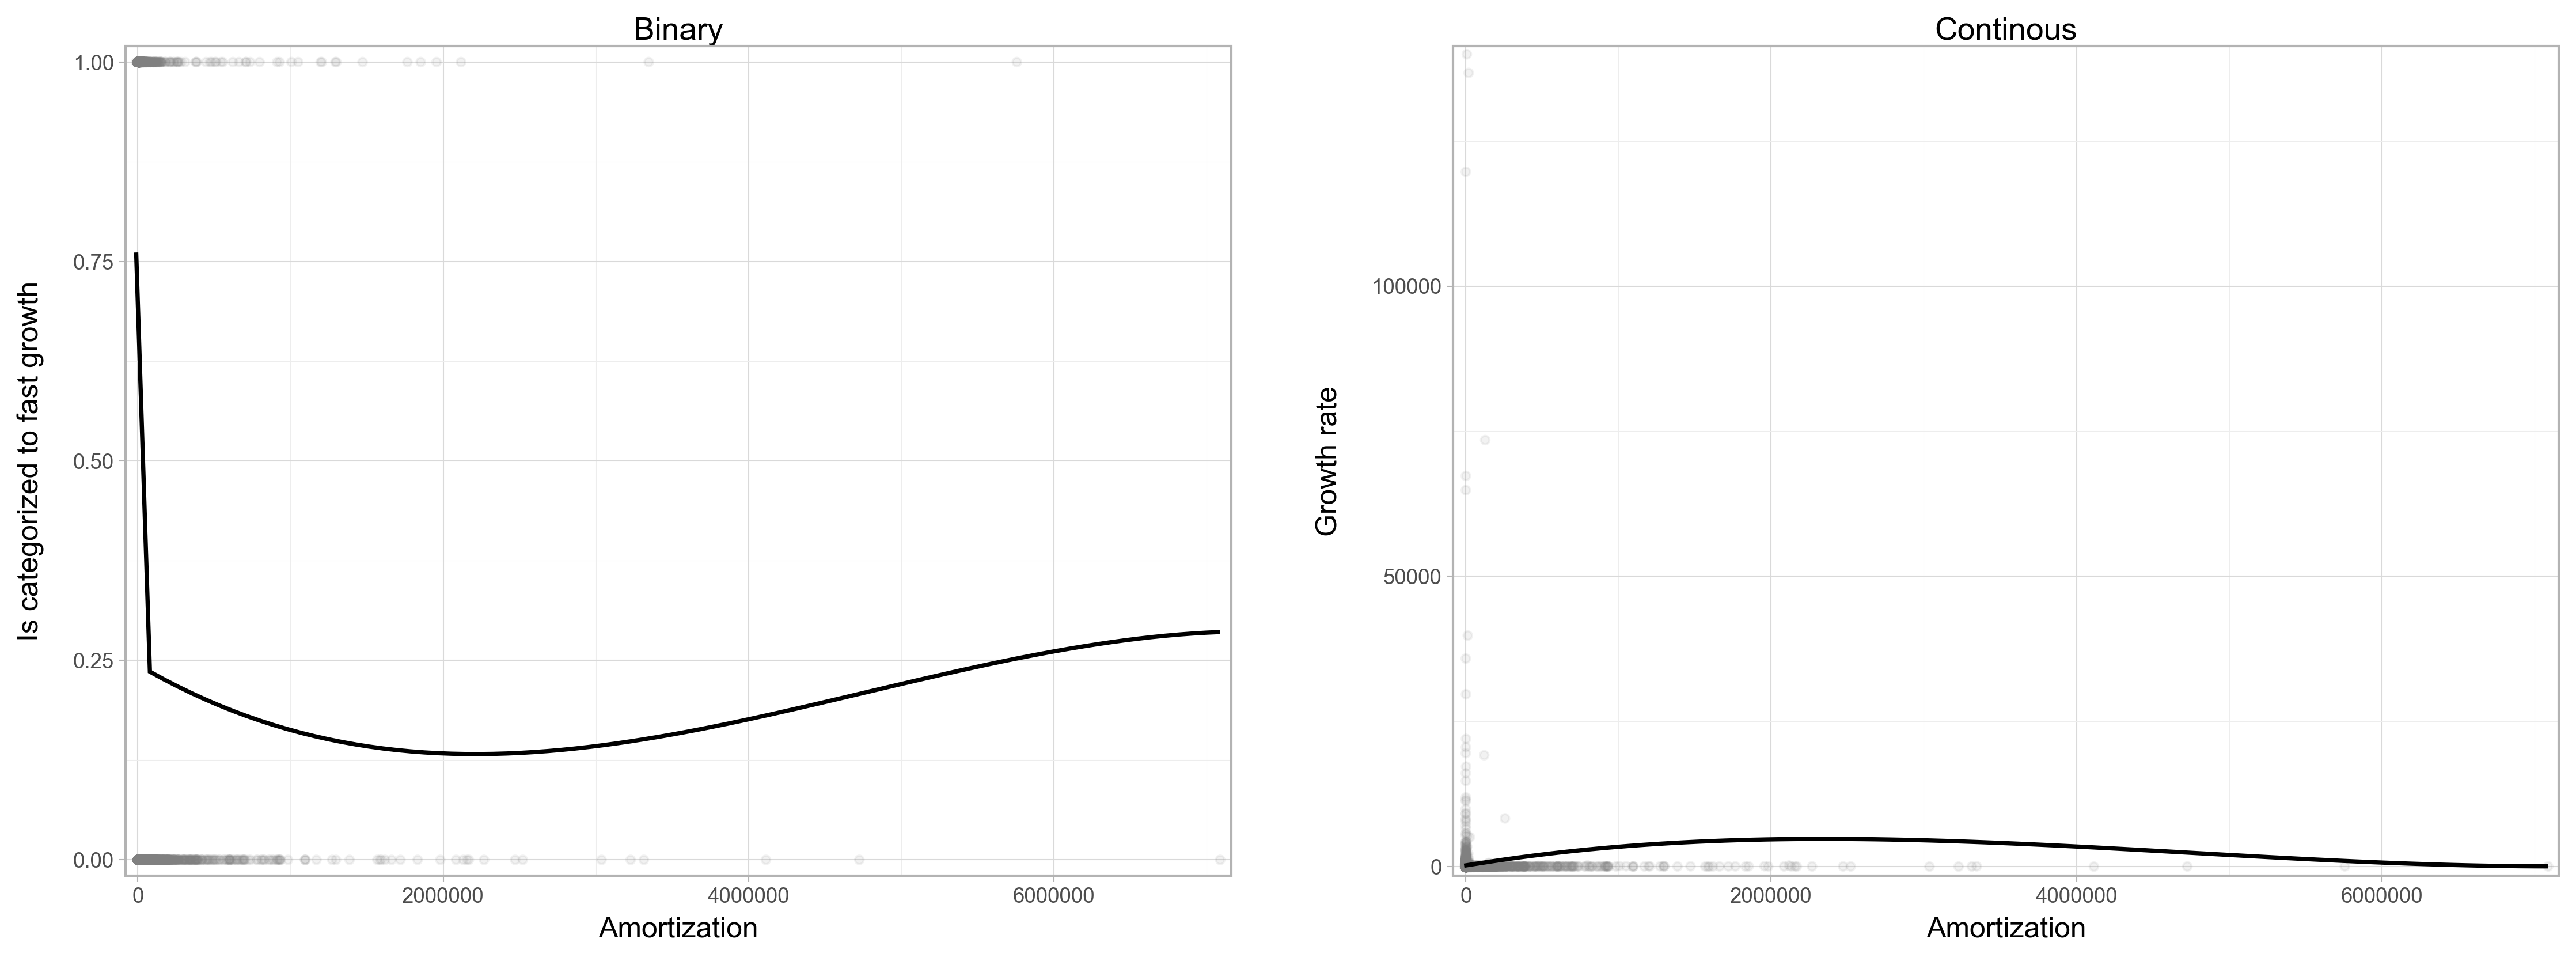

Error in plotting Extra Expenditures (PL) (f_growth): b'svddc failed in l2fit.'
Error in plotting Extra Expenditures (PL) (growth): b'svddc failed in l2fit.'
Skipping combination of plots for Extra Expenditures (PL) due to errors.
Error in plotting Extra Income (PL) (f_growth): b'svddc failed in l2fit.'
Error in plotting Extra Income (PL) (growth): b'svddc failed in l2fit.'
Skipping combination of plots for Extra Income (PL) due to errors.
Error in plotting Extra Profit/Loss (PL) (f_growth): b'reciprocal condition number  6.9003e-18'
Error in plotting Extra Profit/Loss (PL) (growth): b'reciprocal condition number  6.9003e-18'
Skipping combination of plots for Extra Profit/Loss (PL) due to errors.


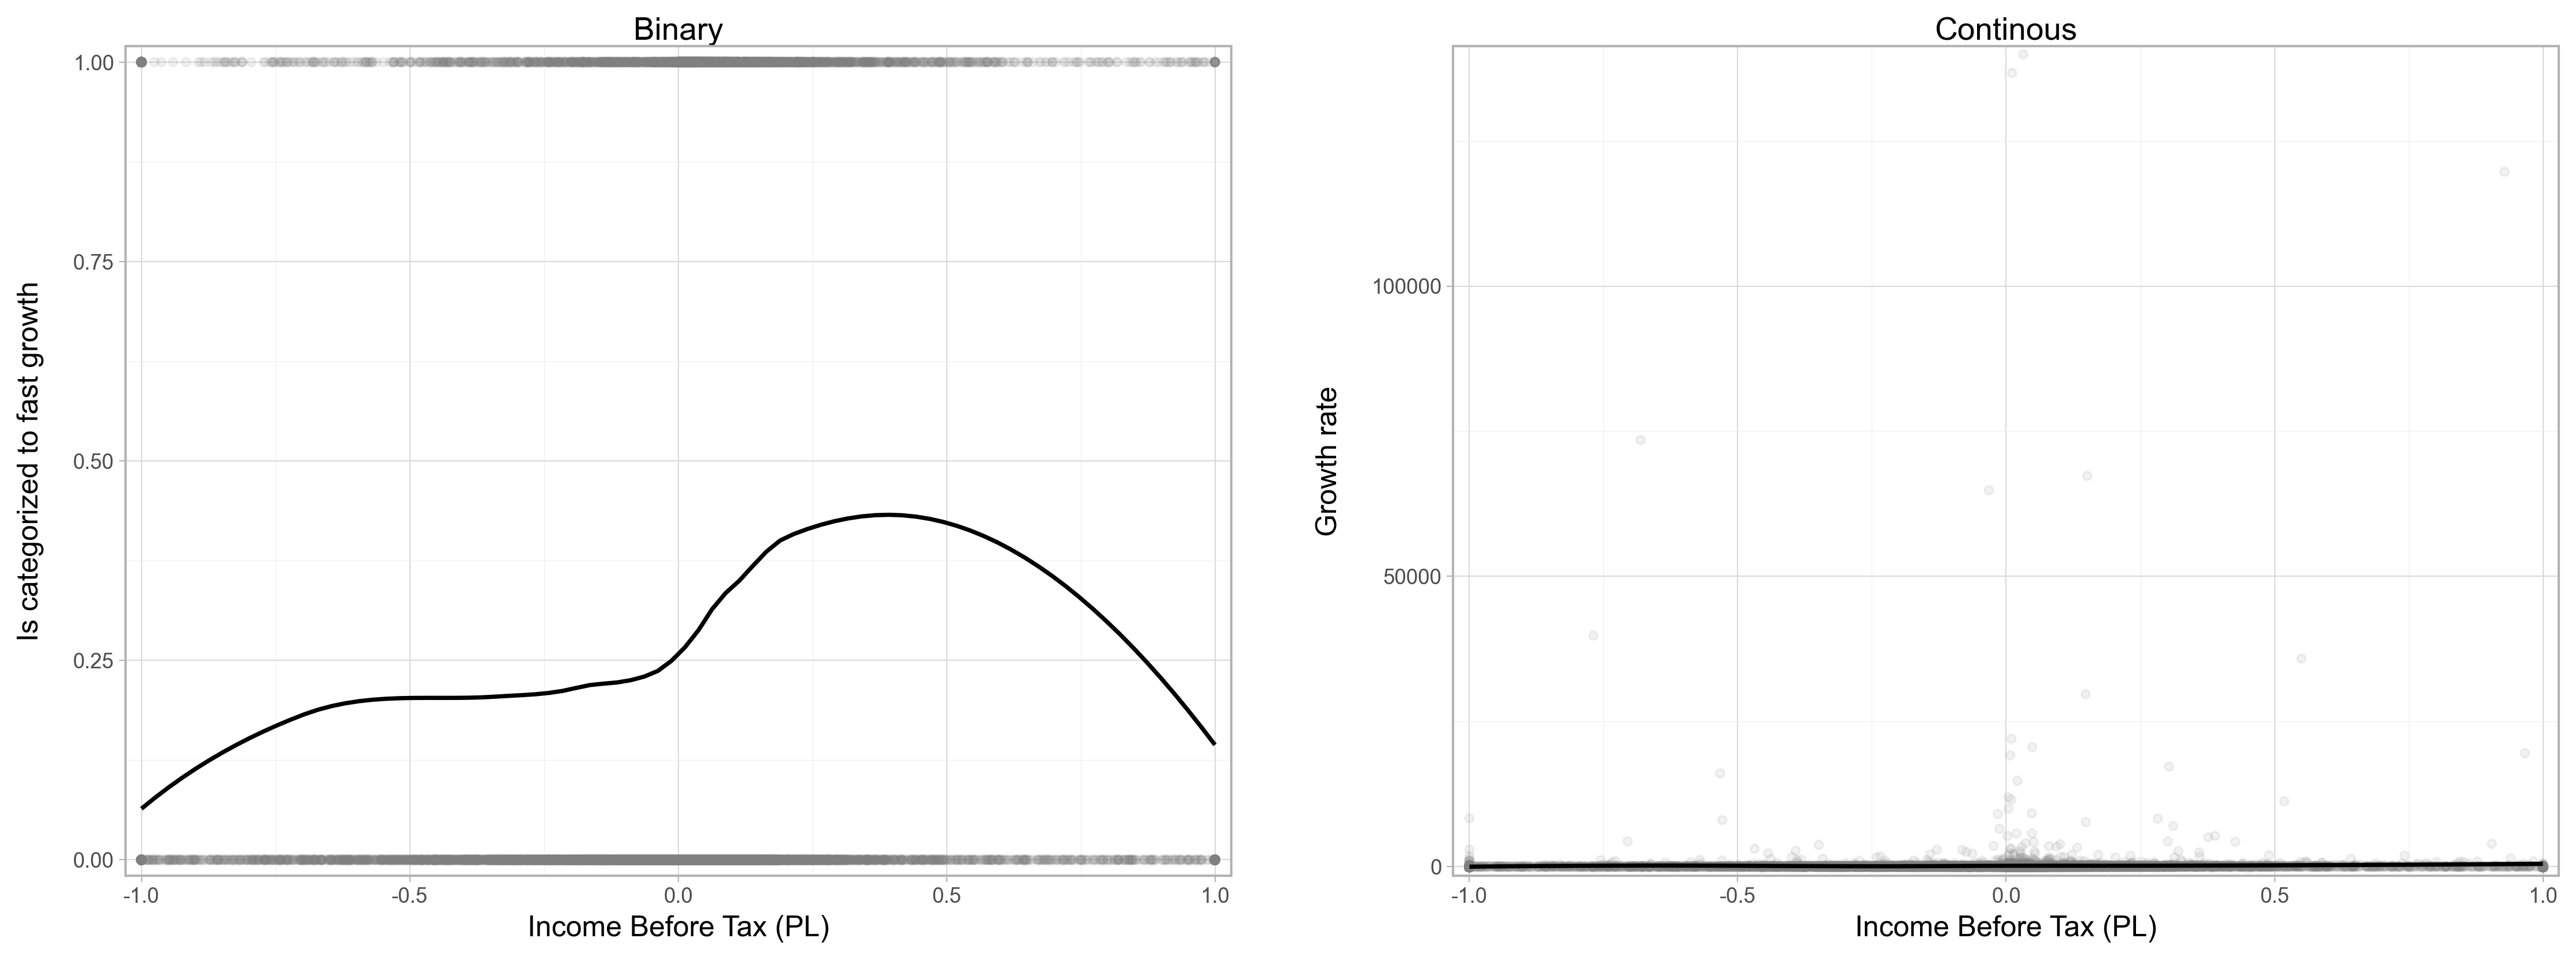

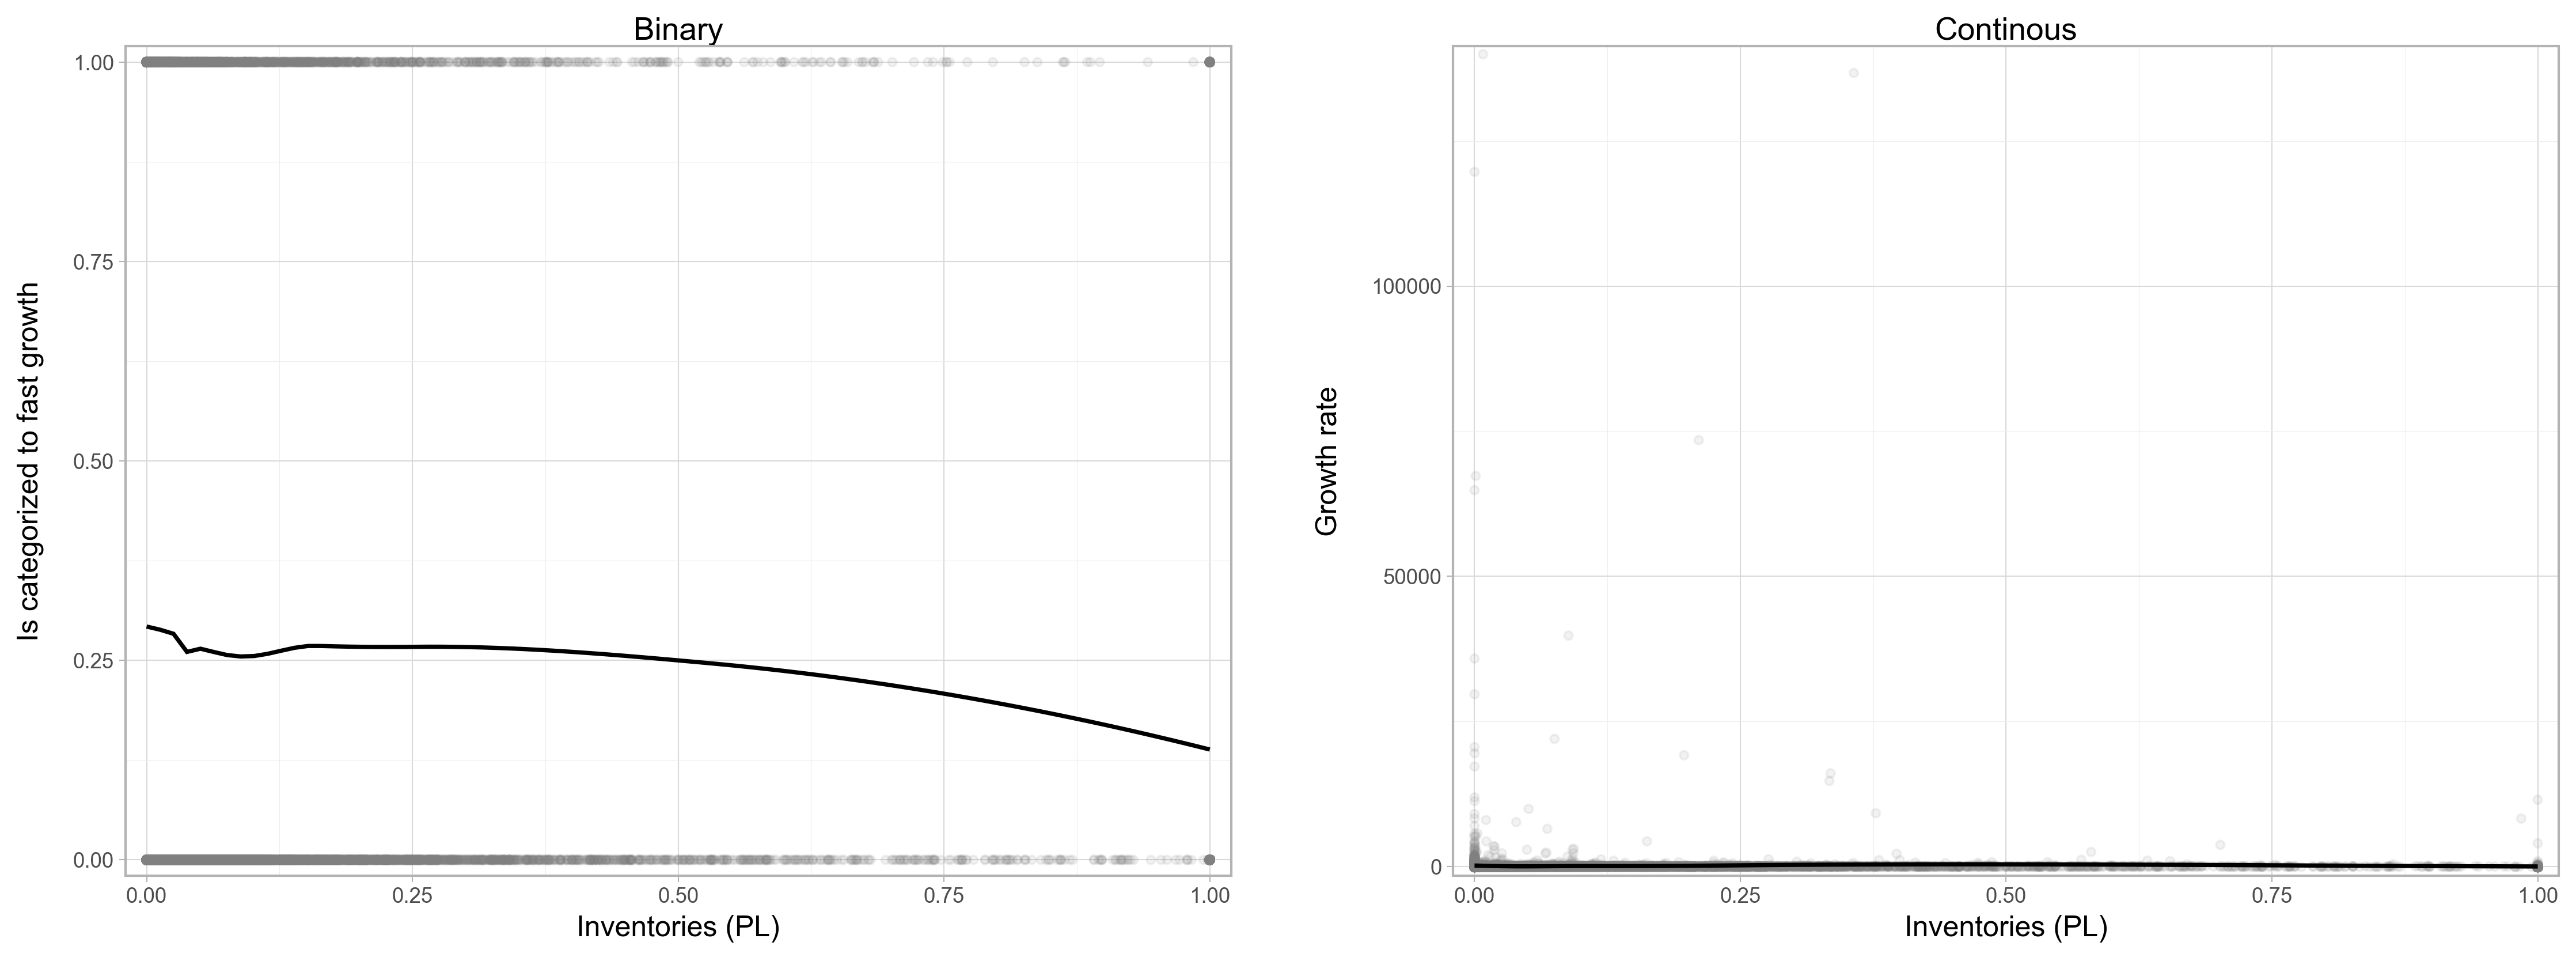

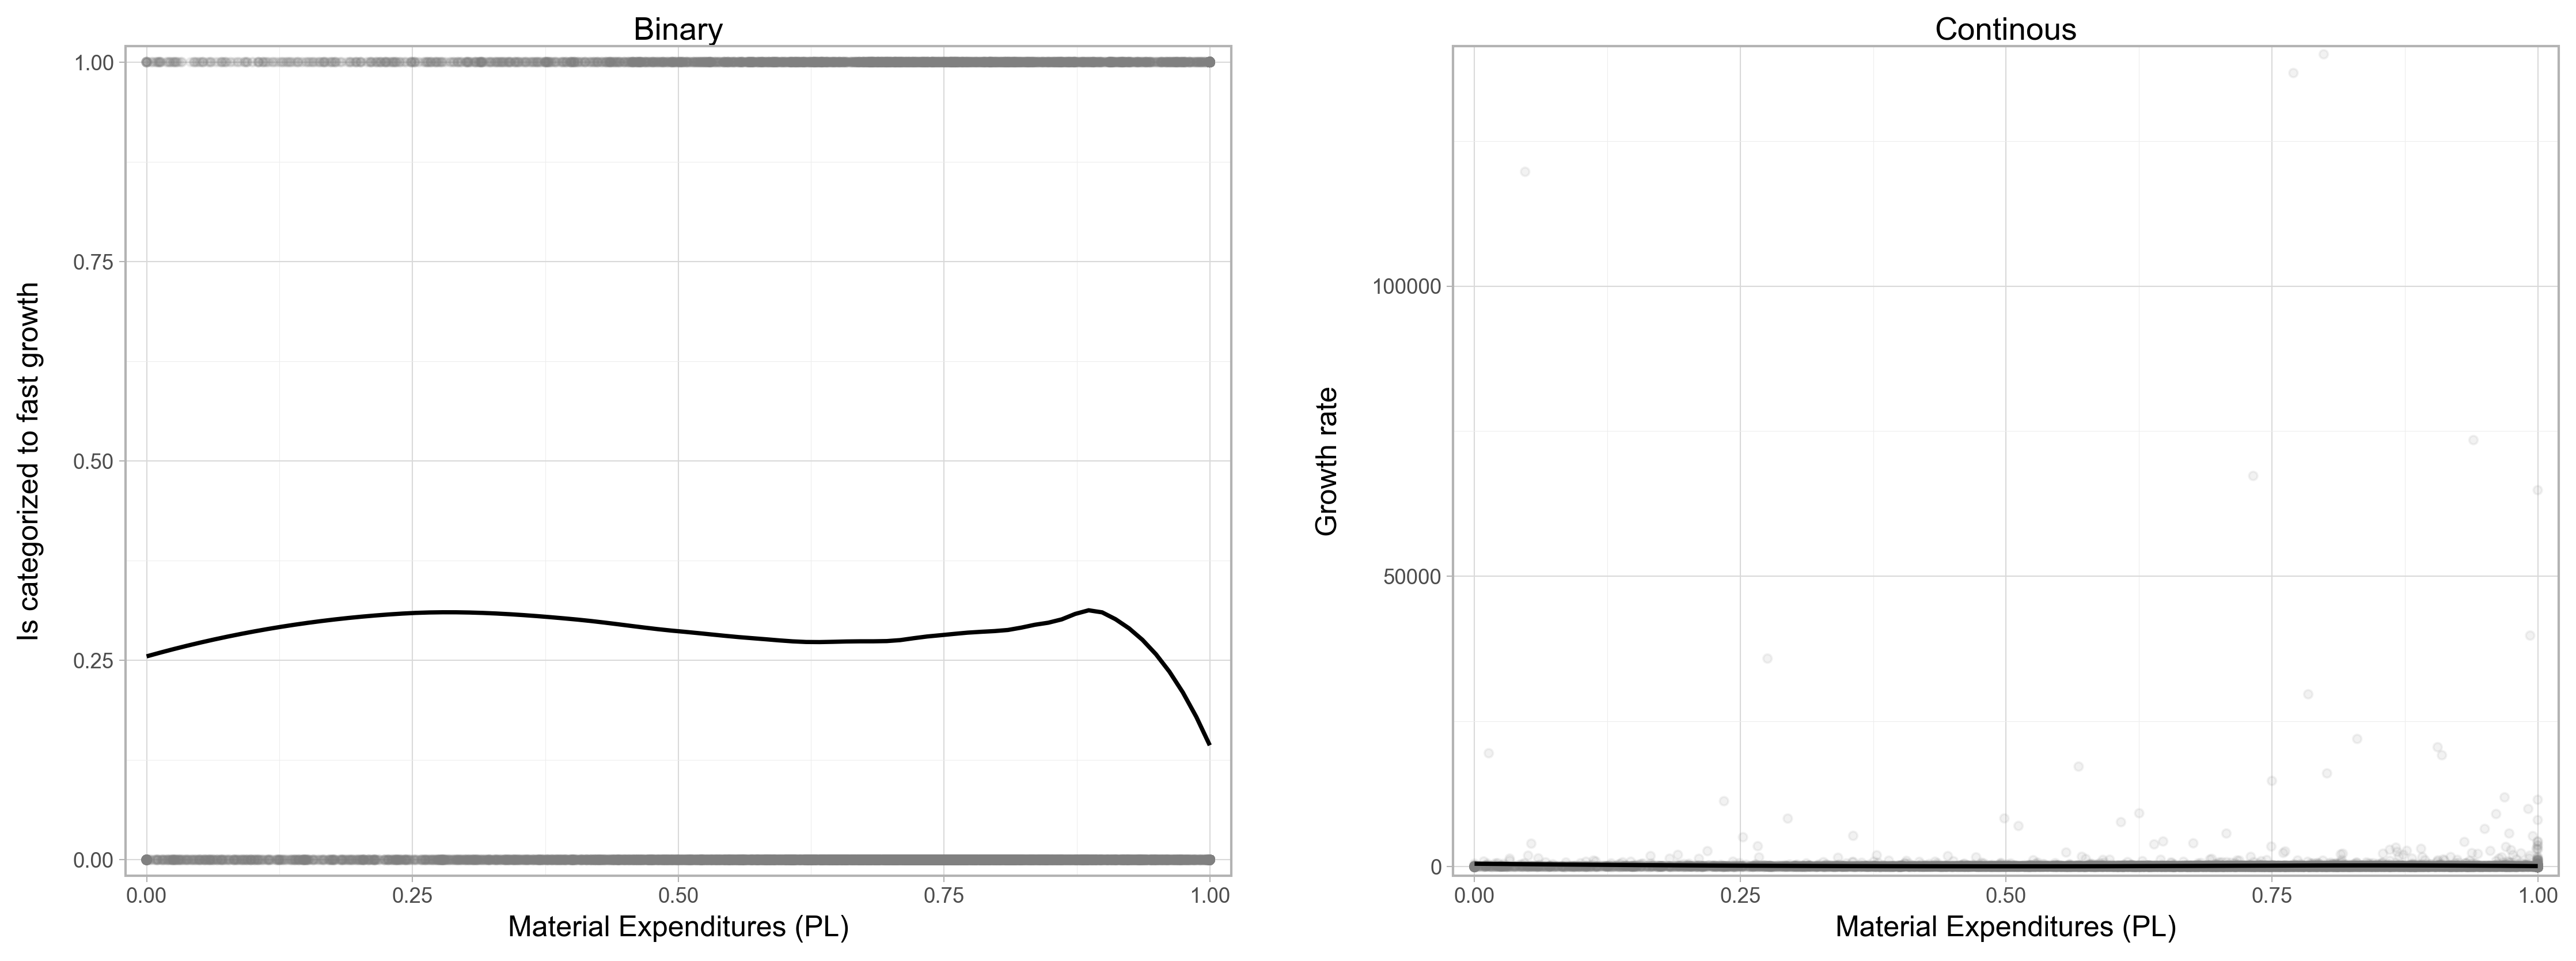

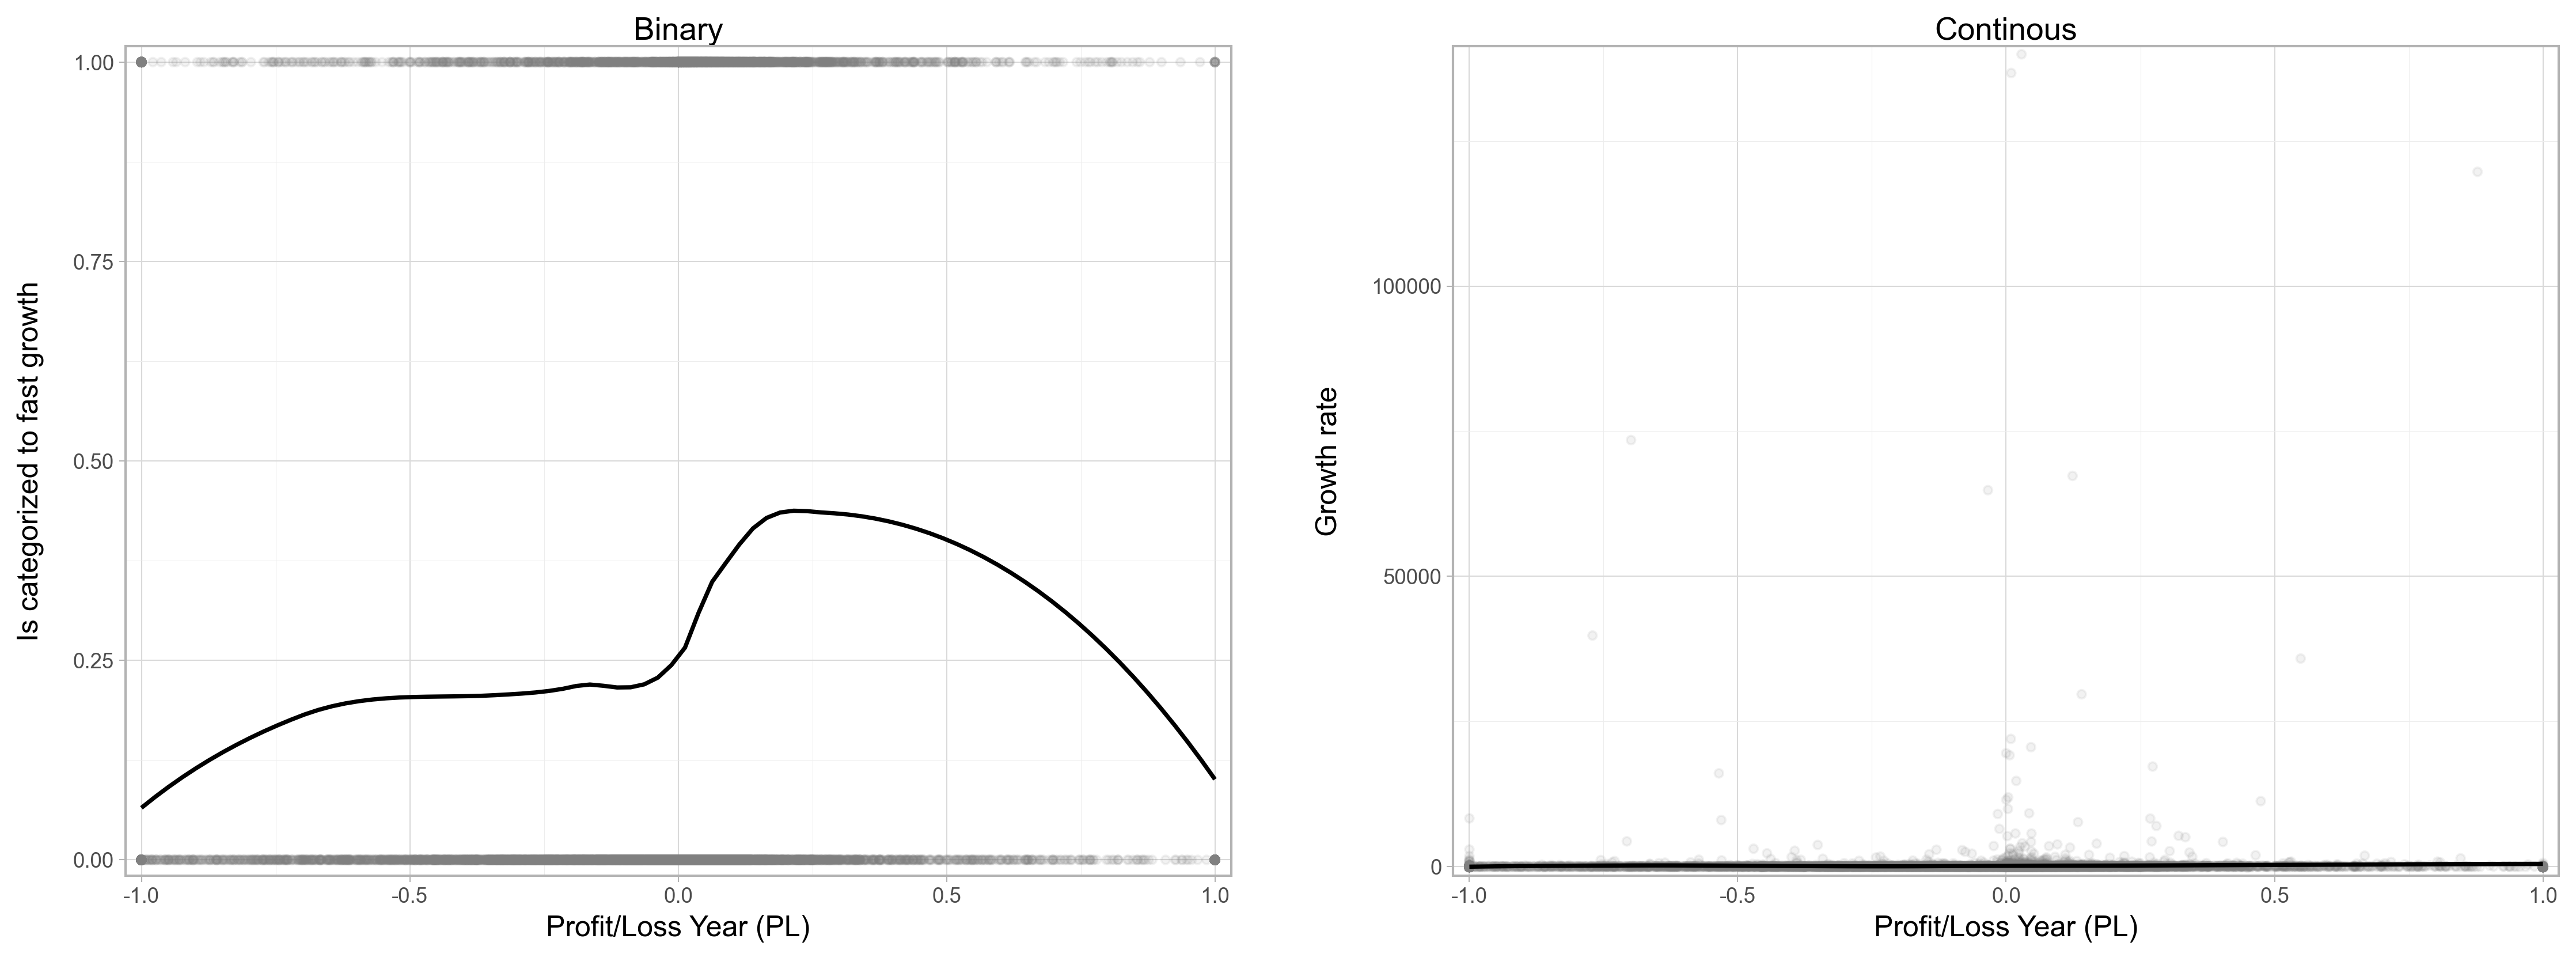

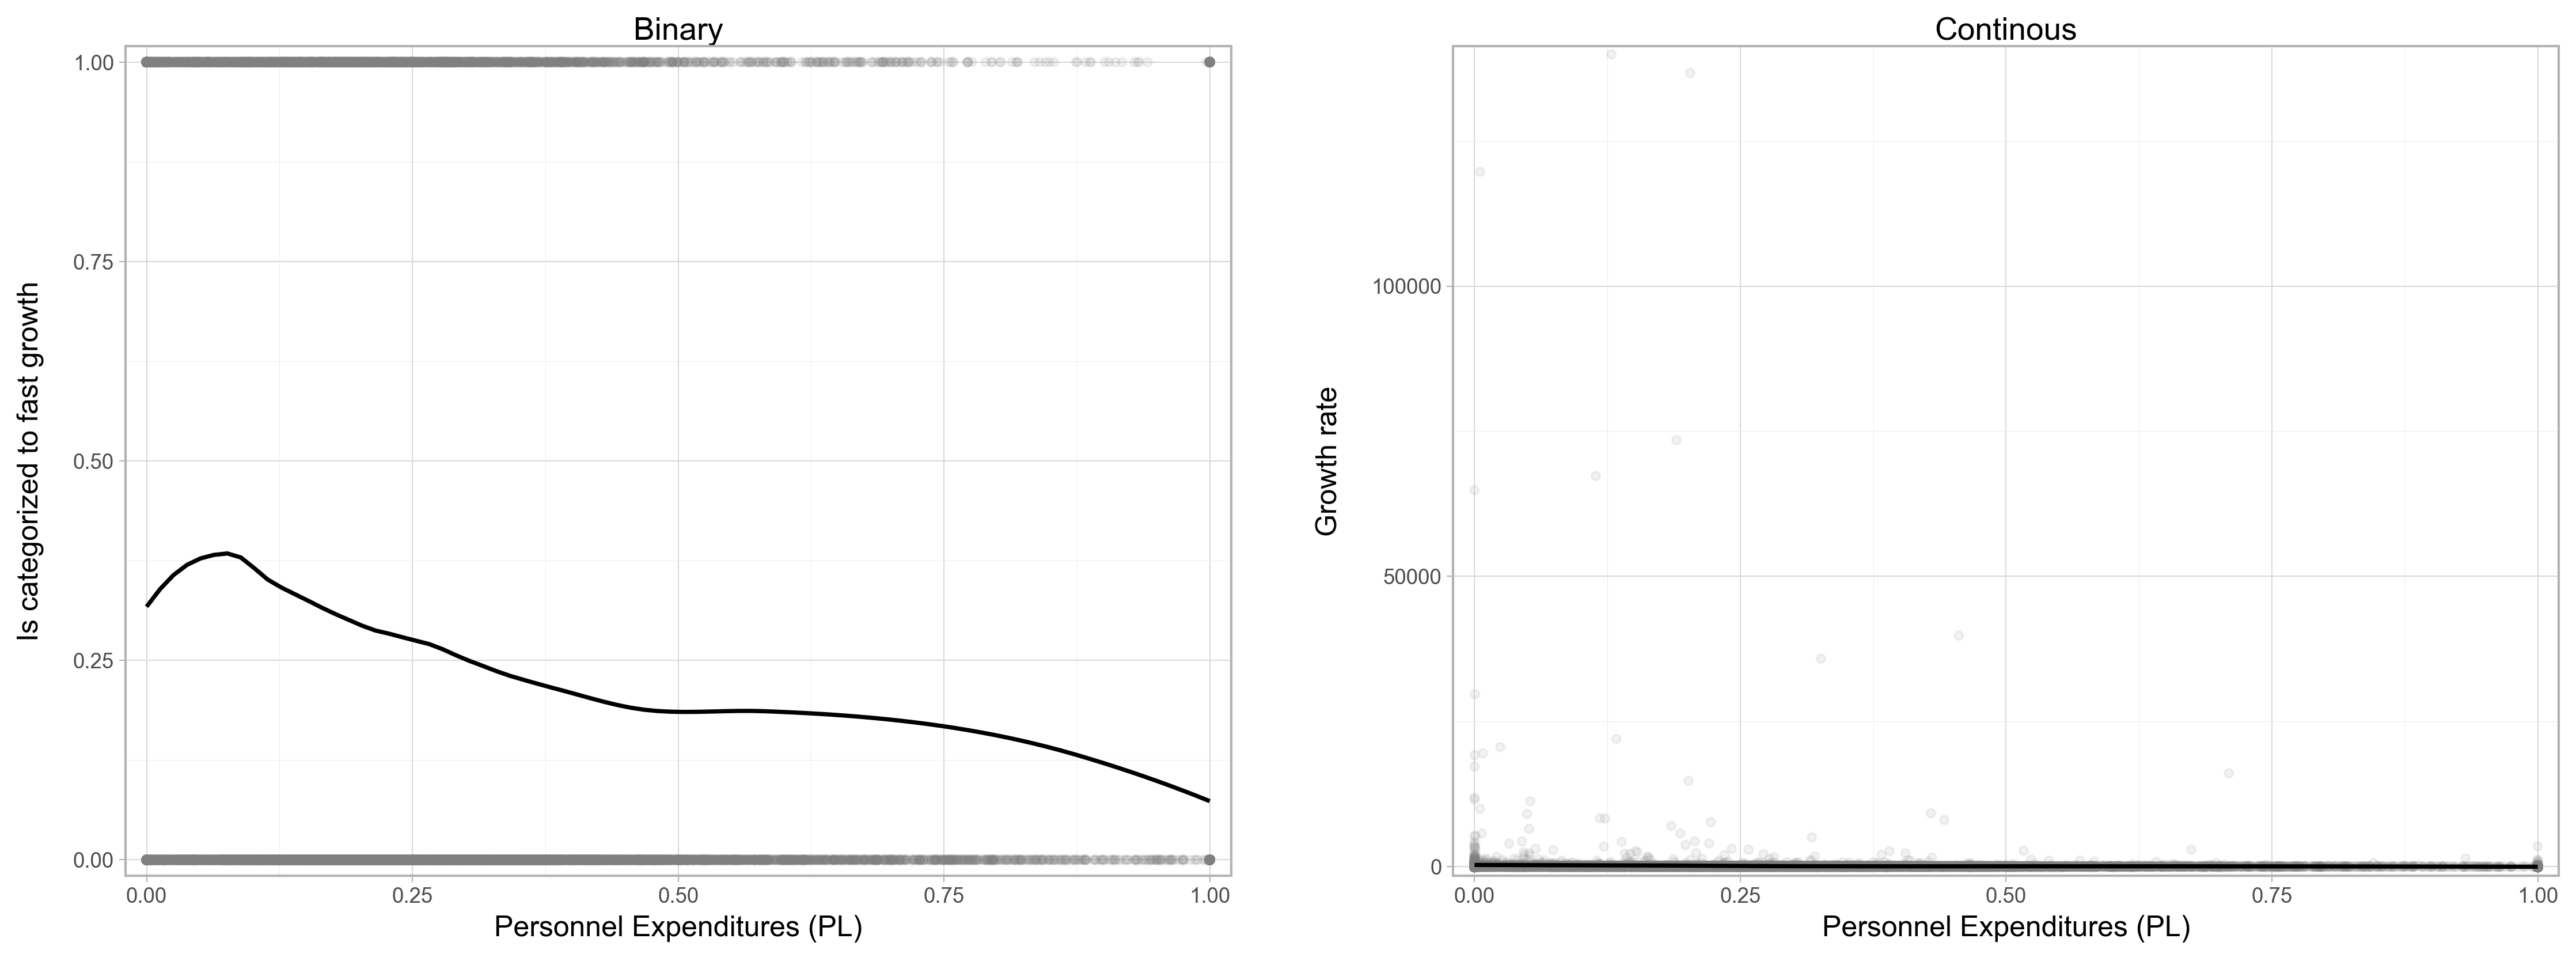

Error in plotting Intangible Assets (Balance Sheet) (f_growth): b'svddc failed in l2fit.'
Error in plotting Intangible Assets (Balance Sheet) (growth): b'svddc failed in l2fit.'
Skipping combination of plots for Intangible Assets (Balance Sheet) due to errors.


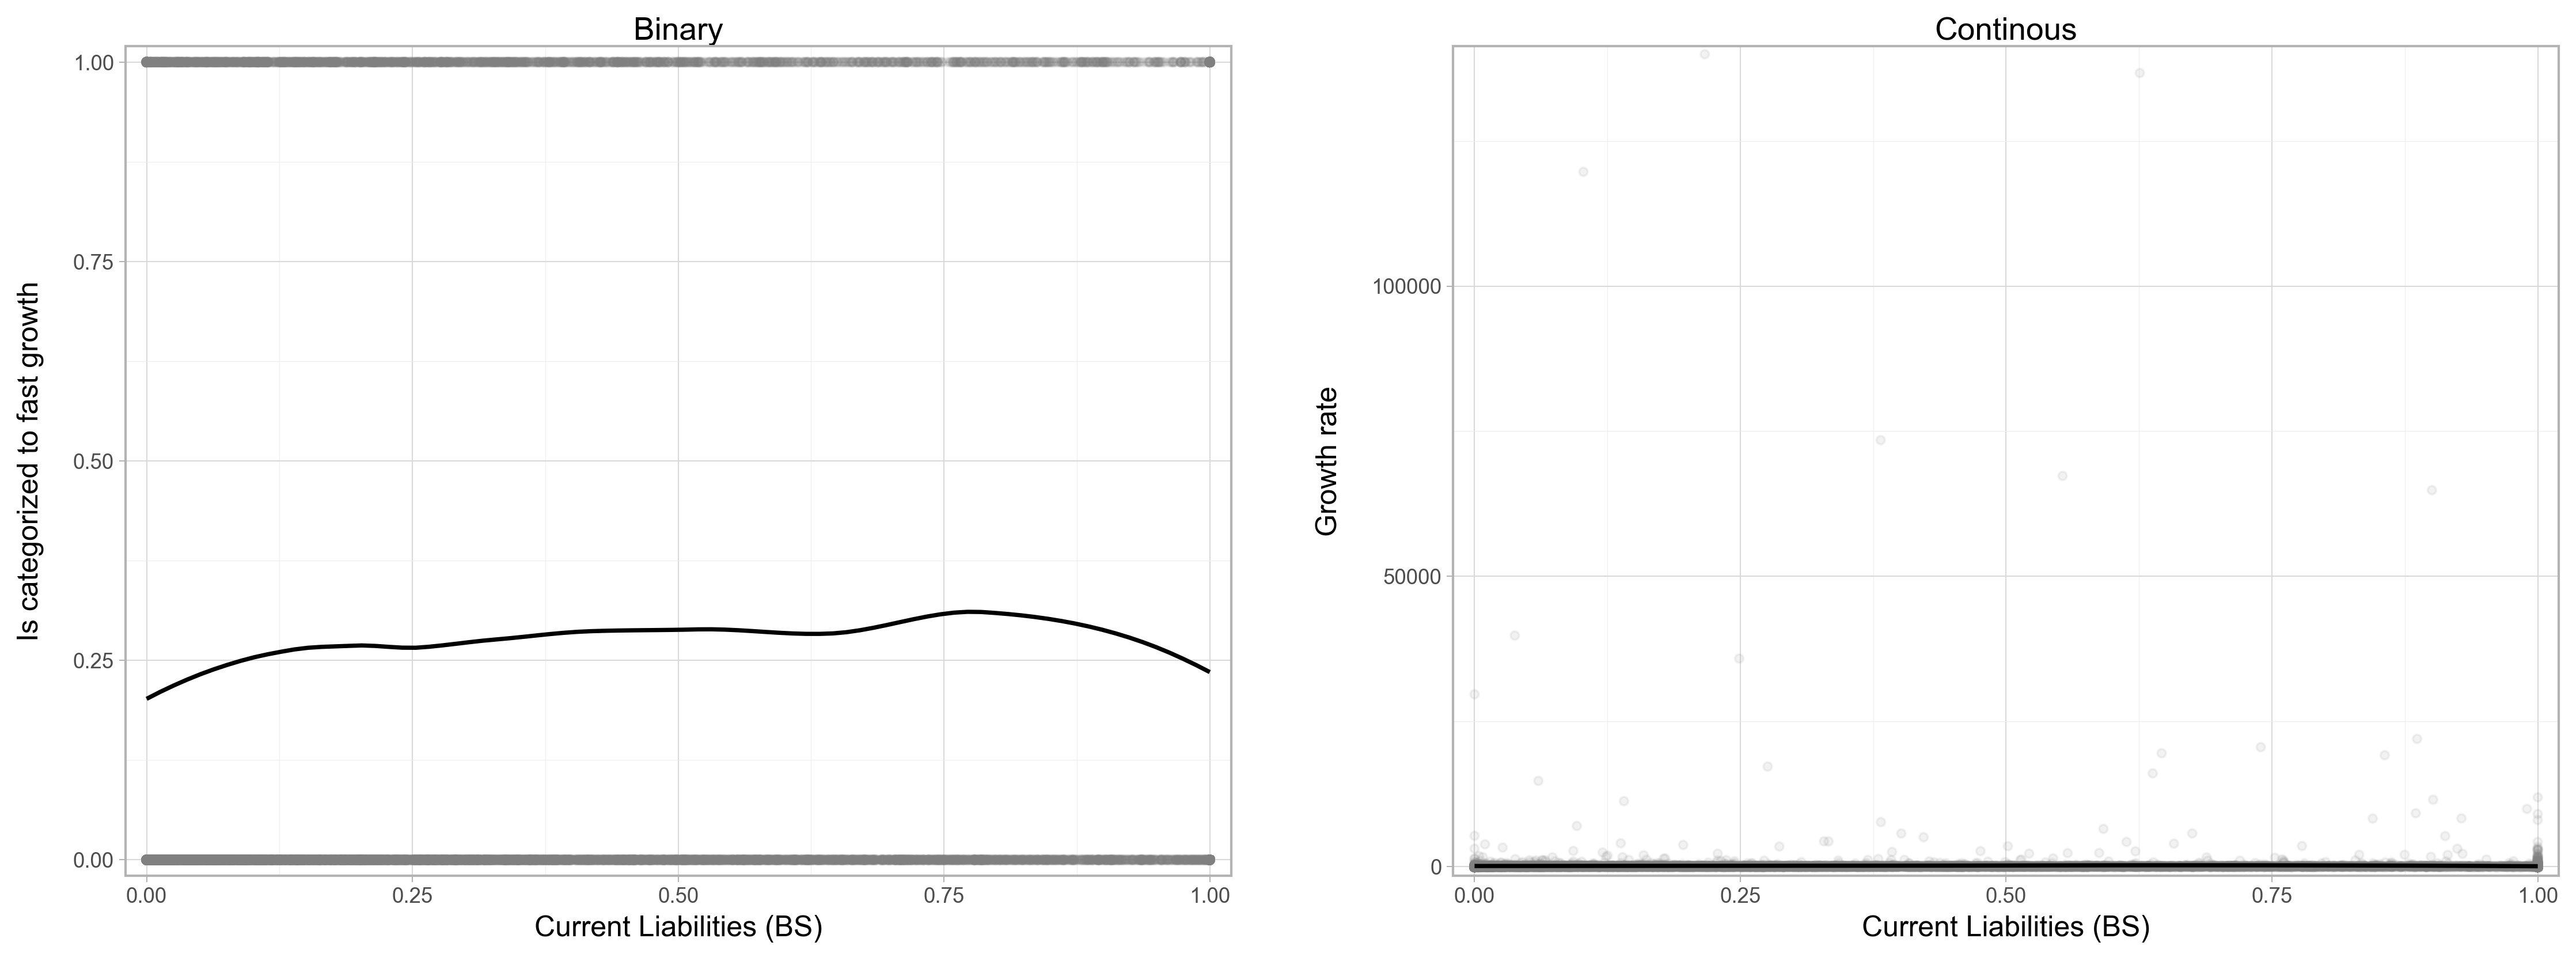

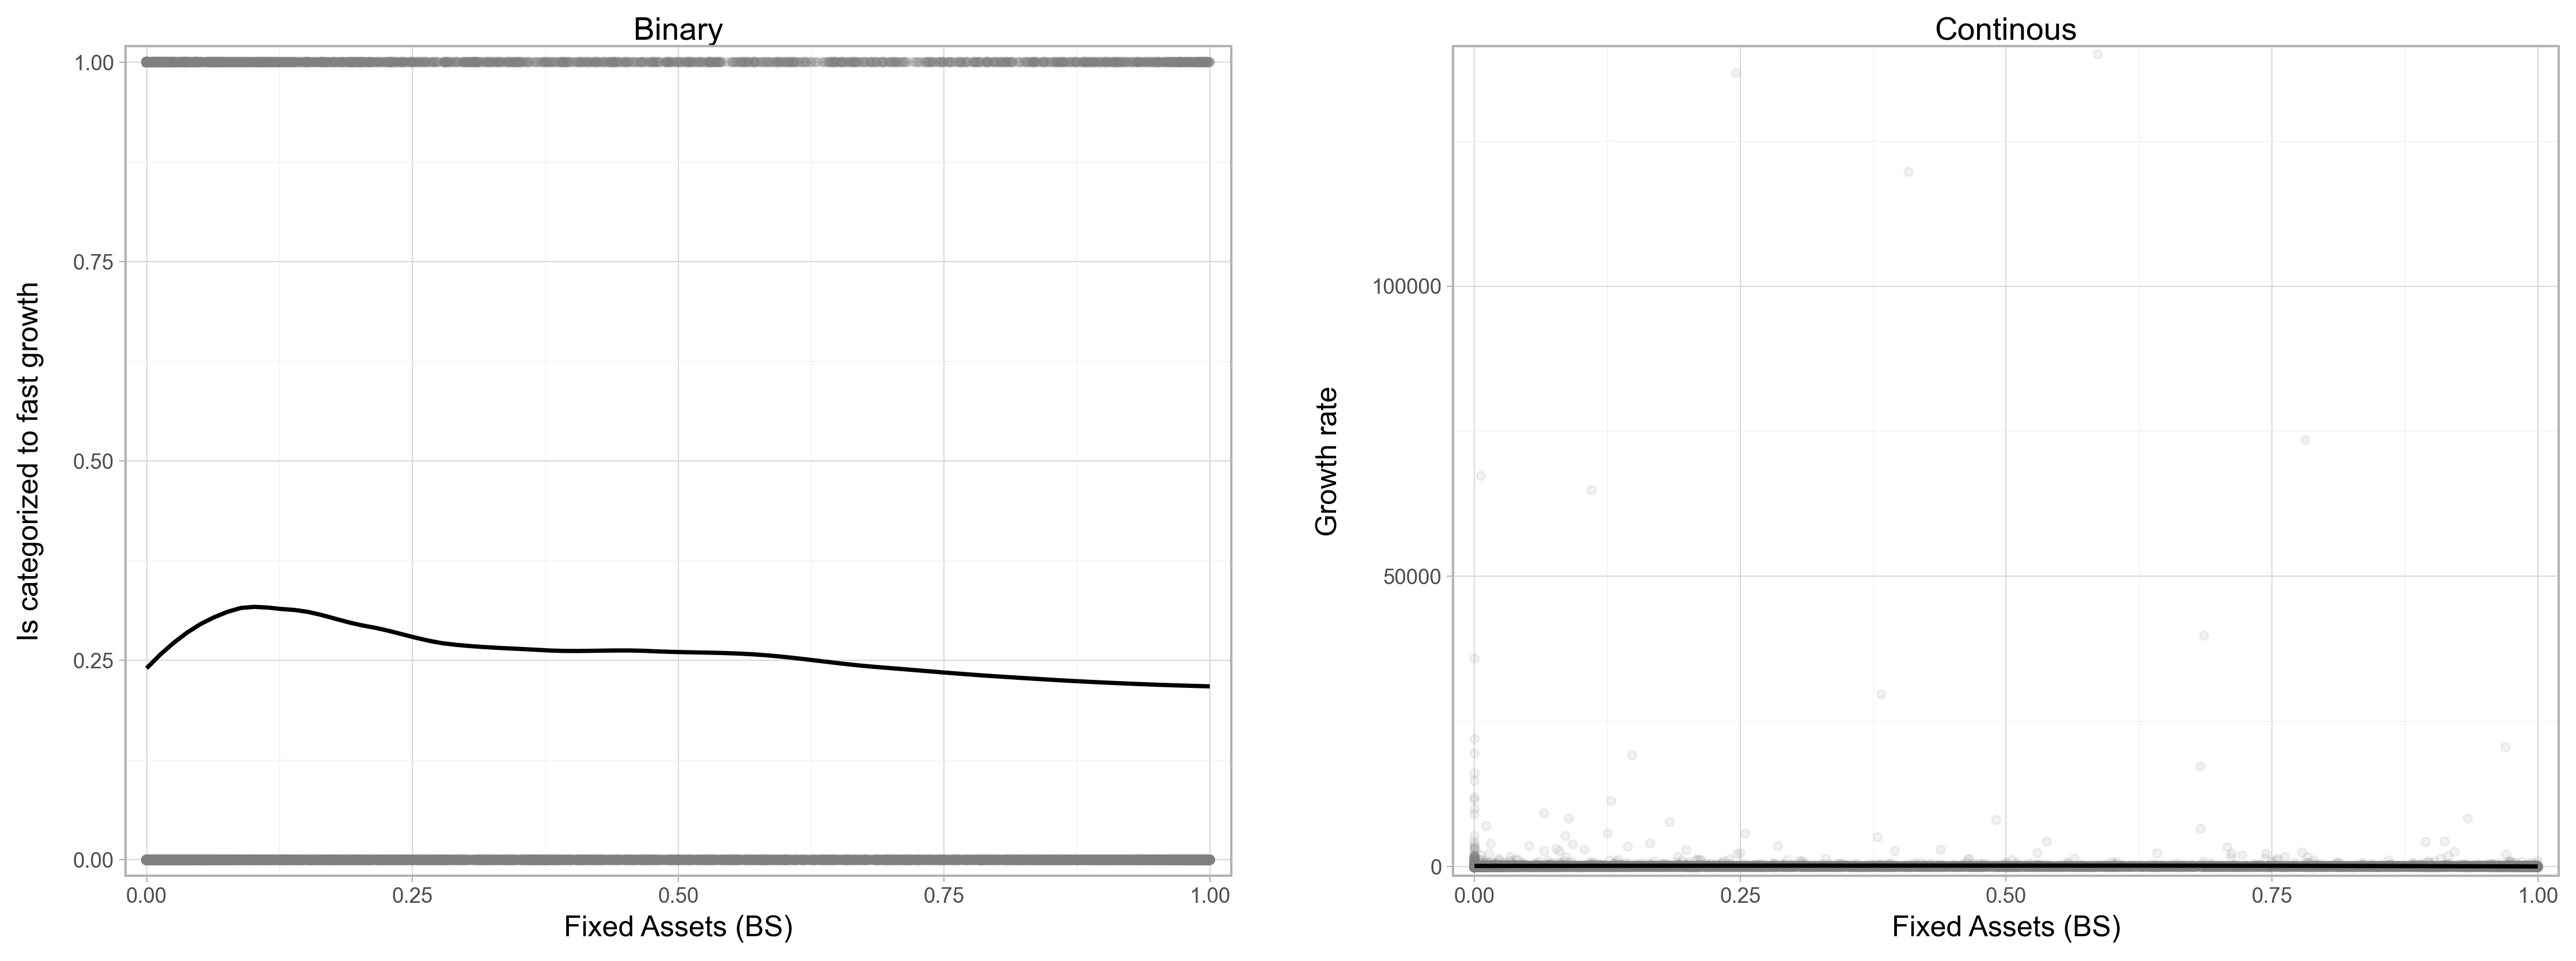

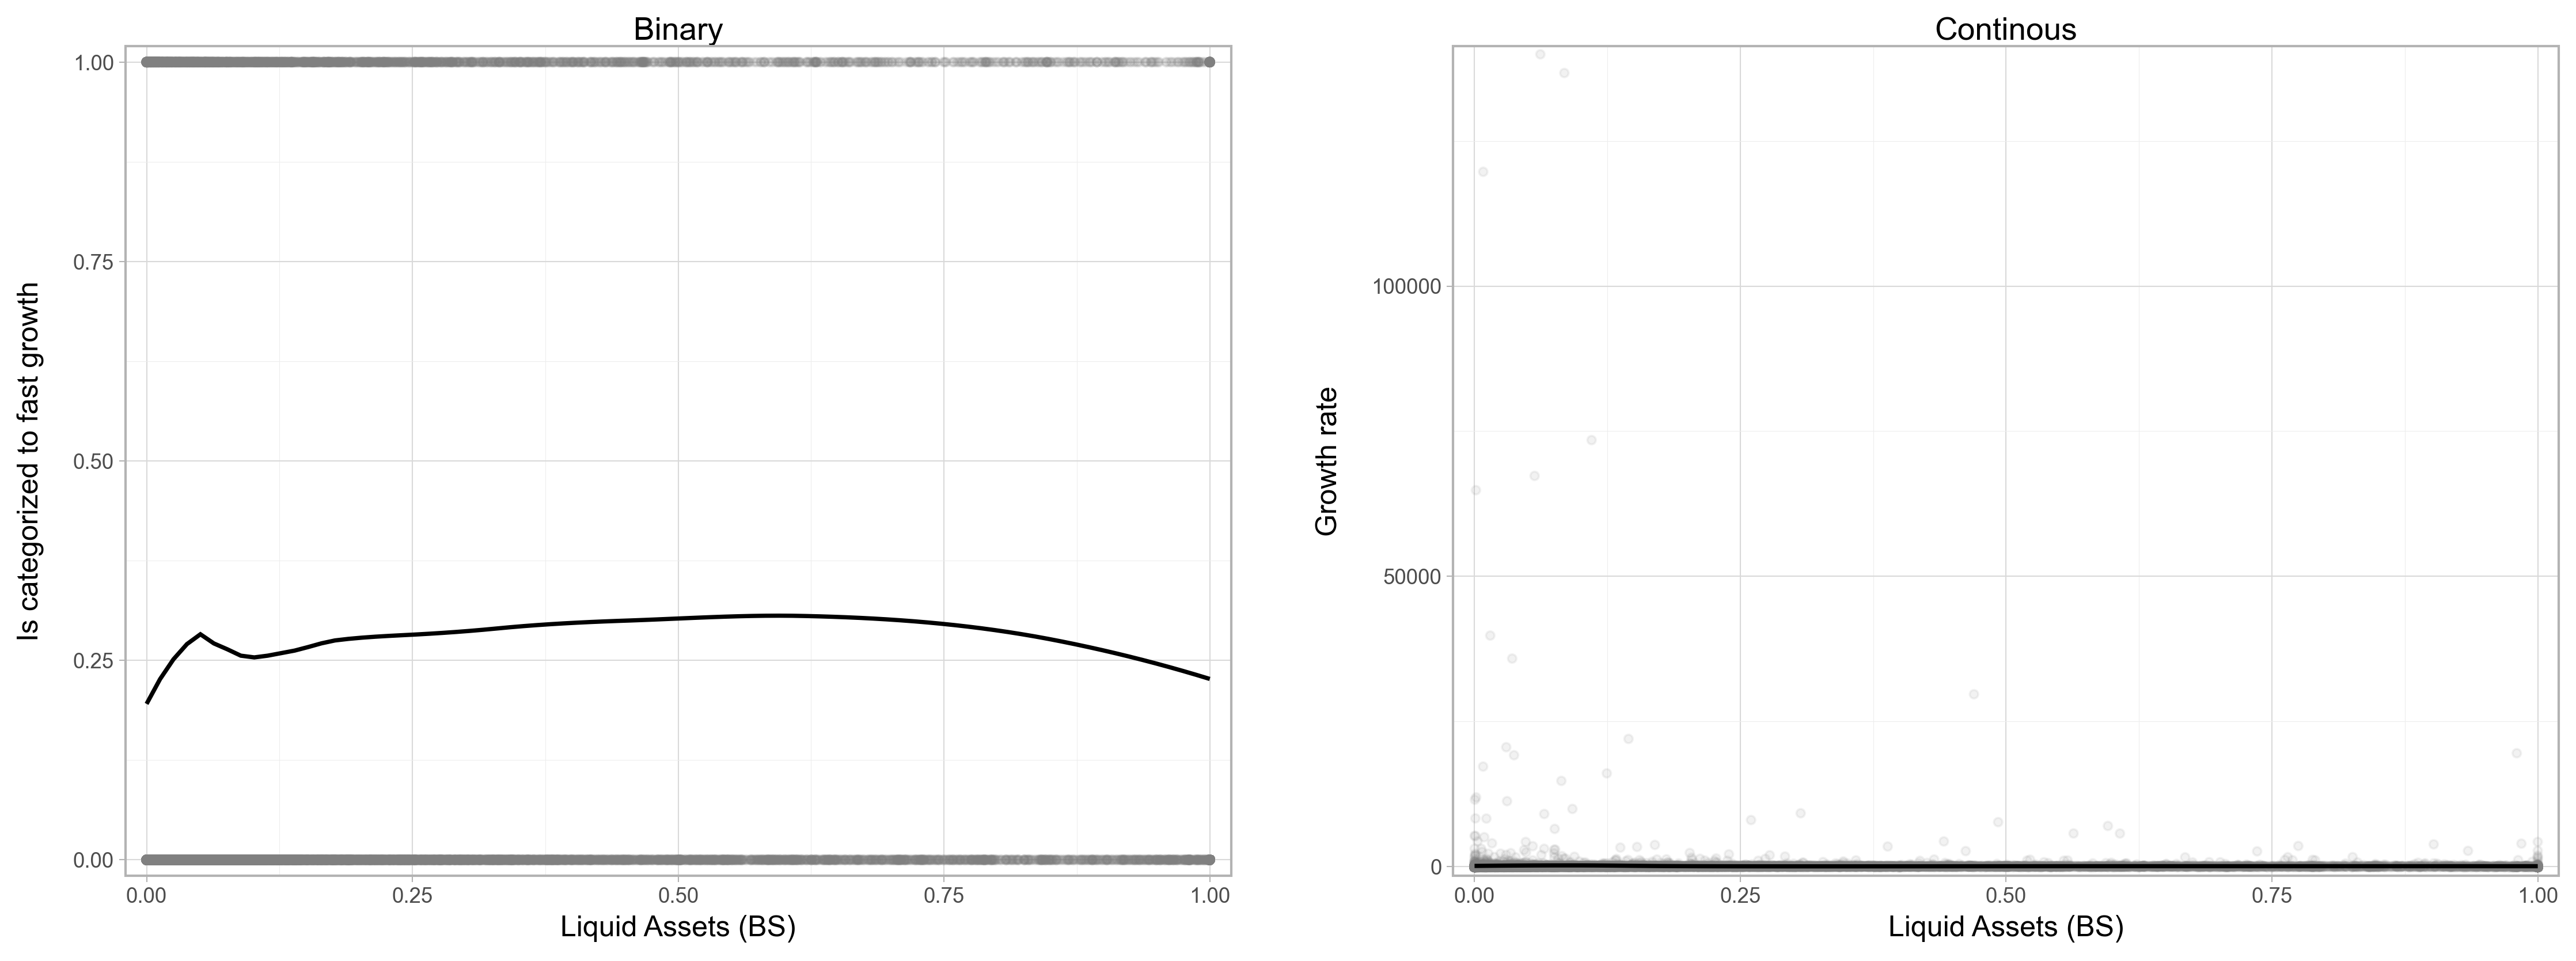

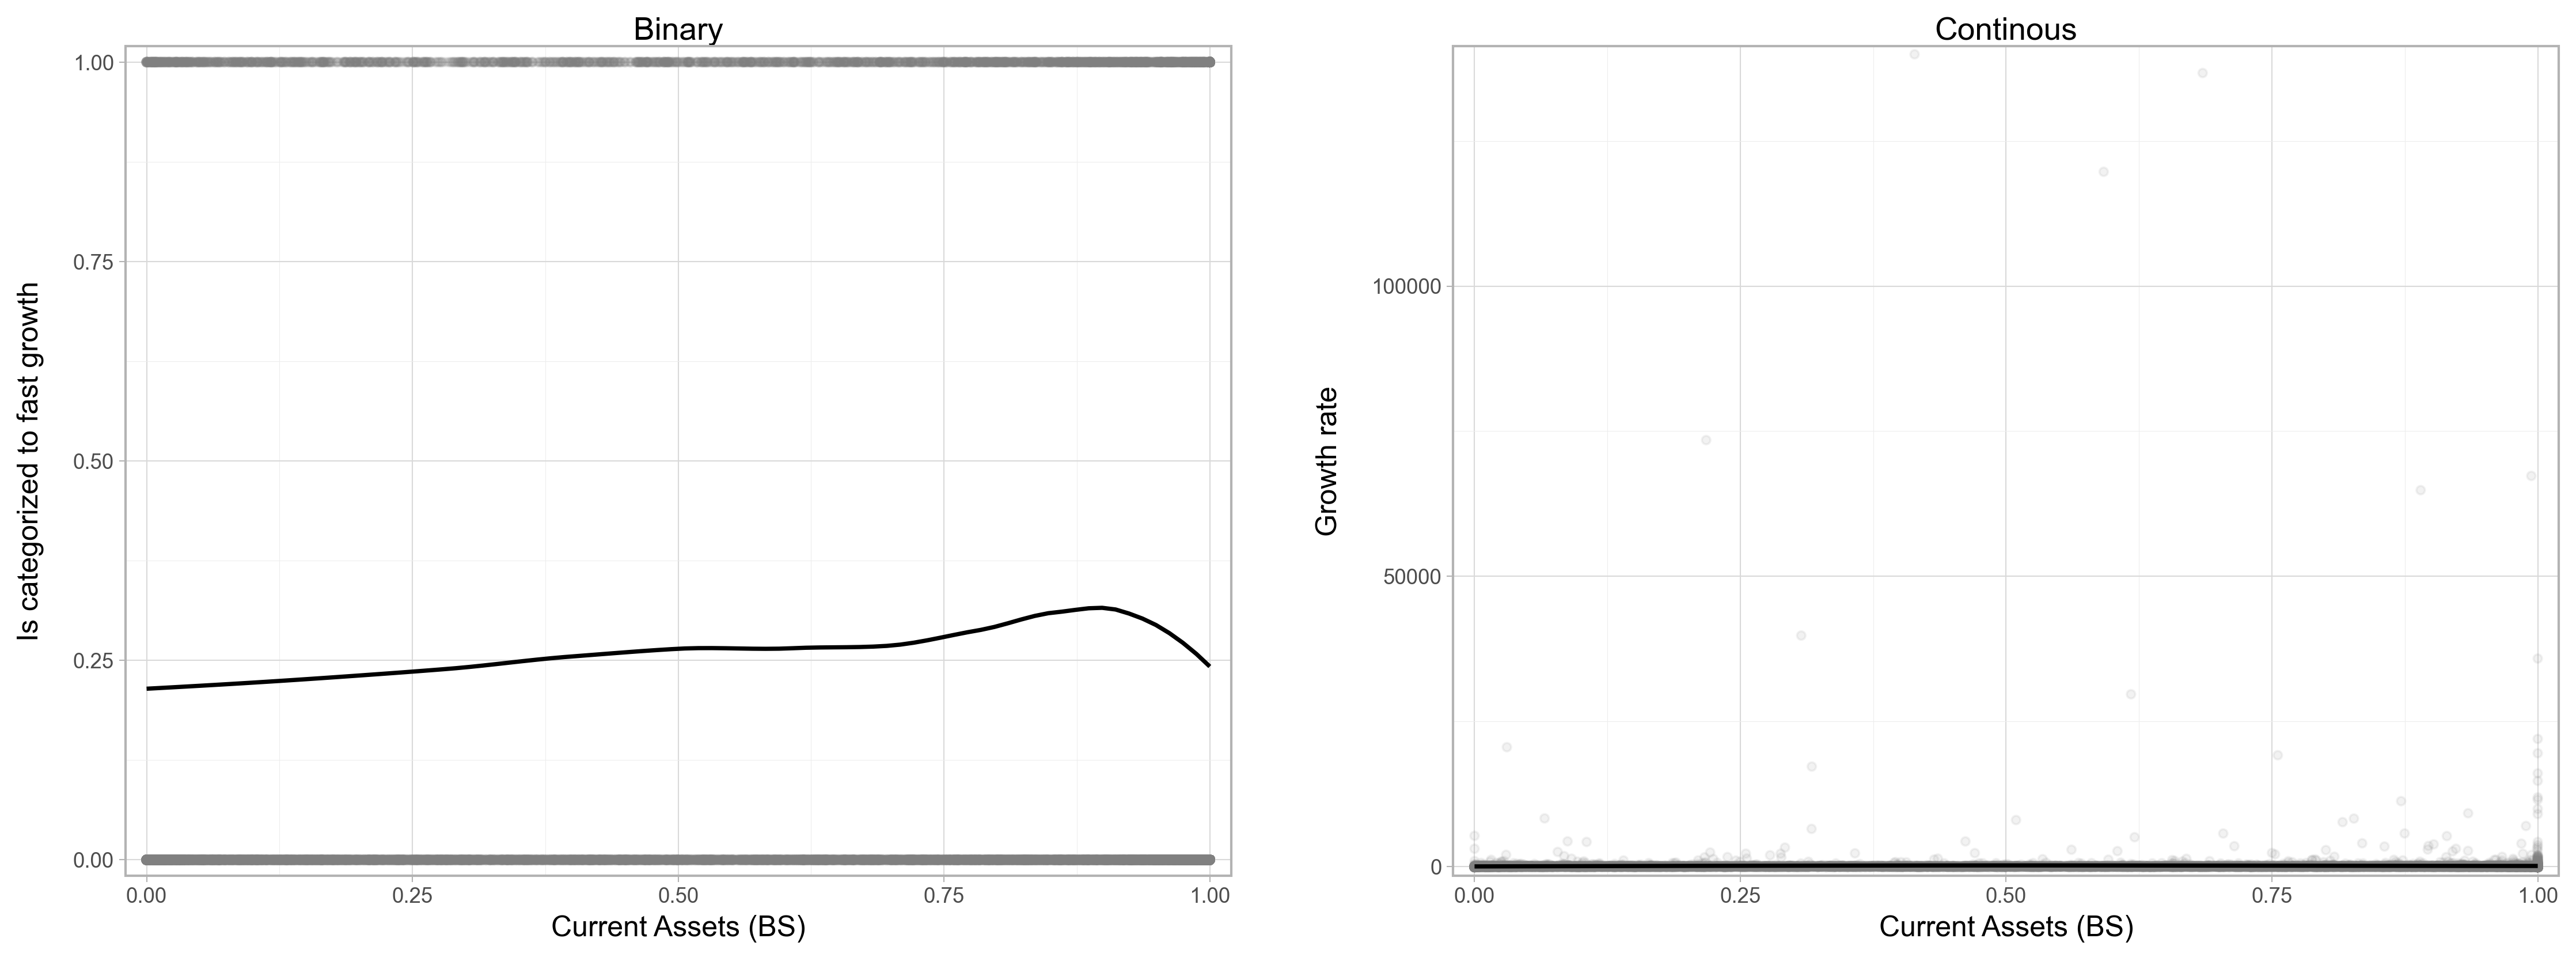

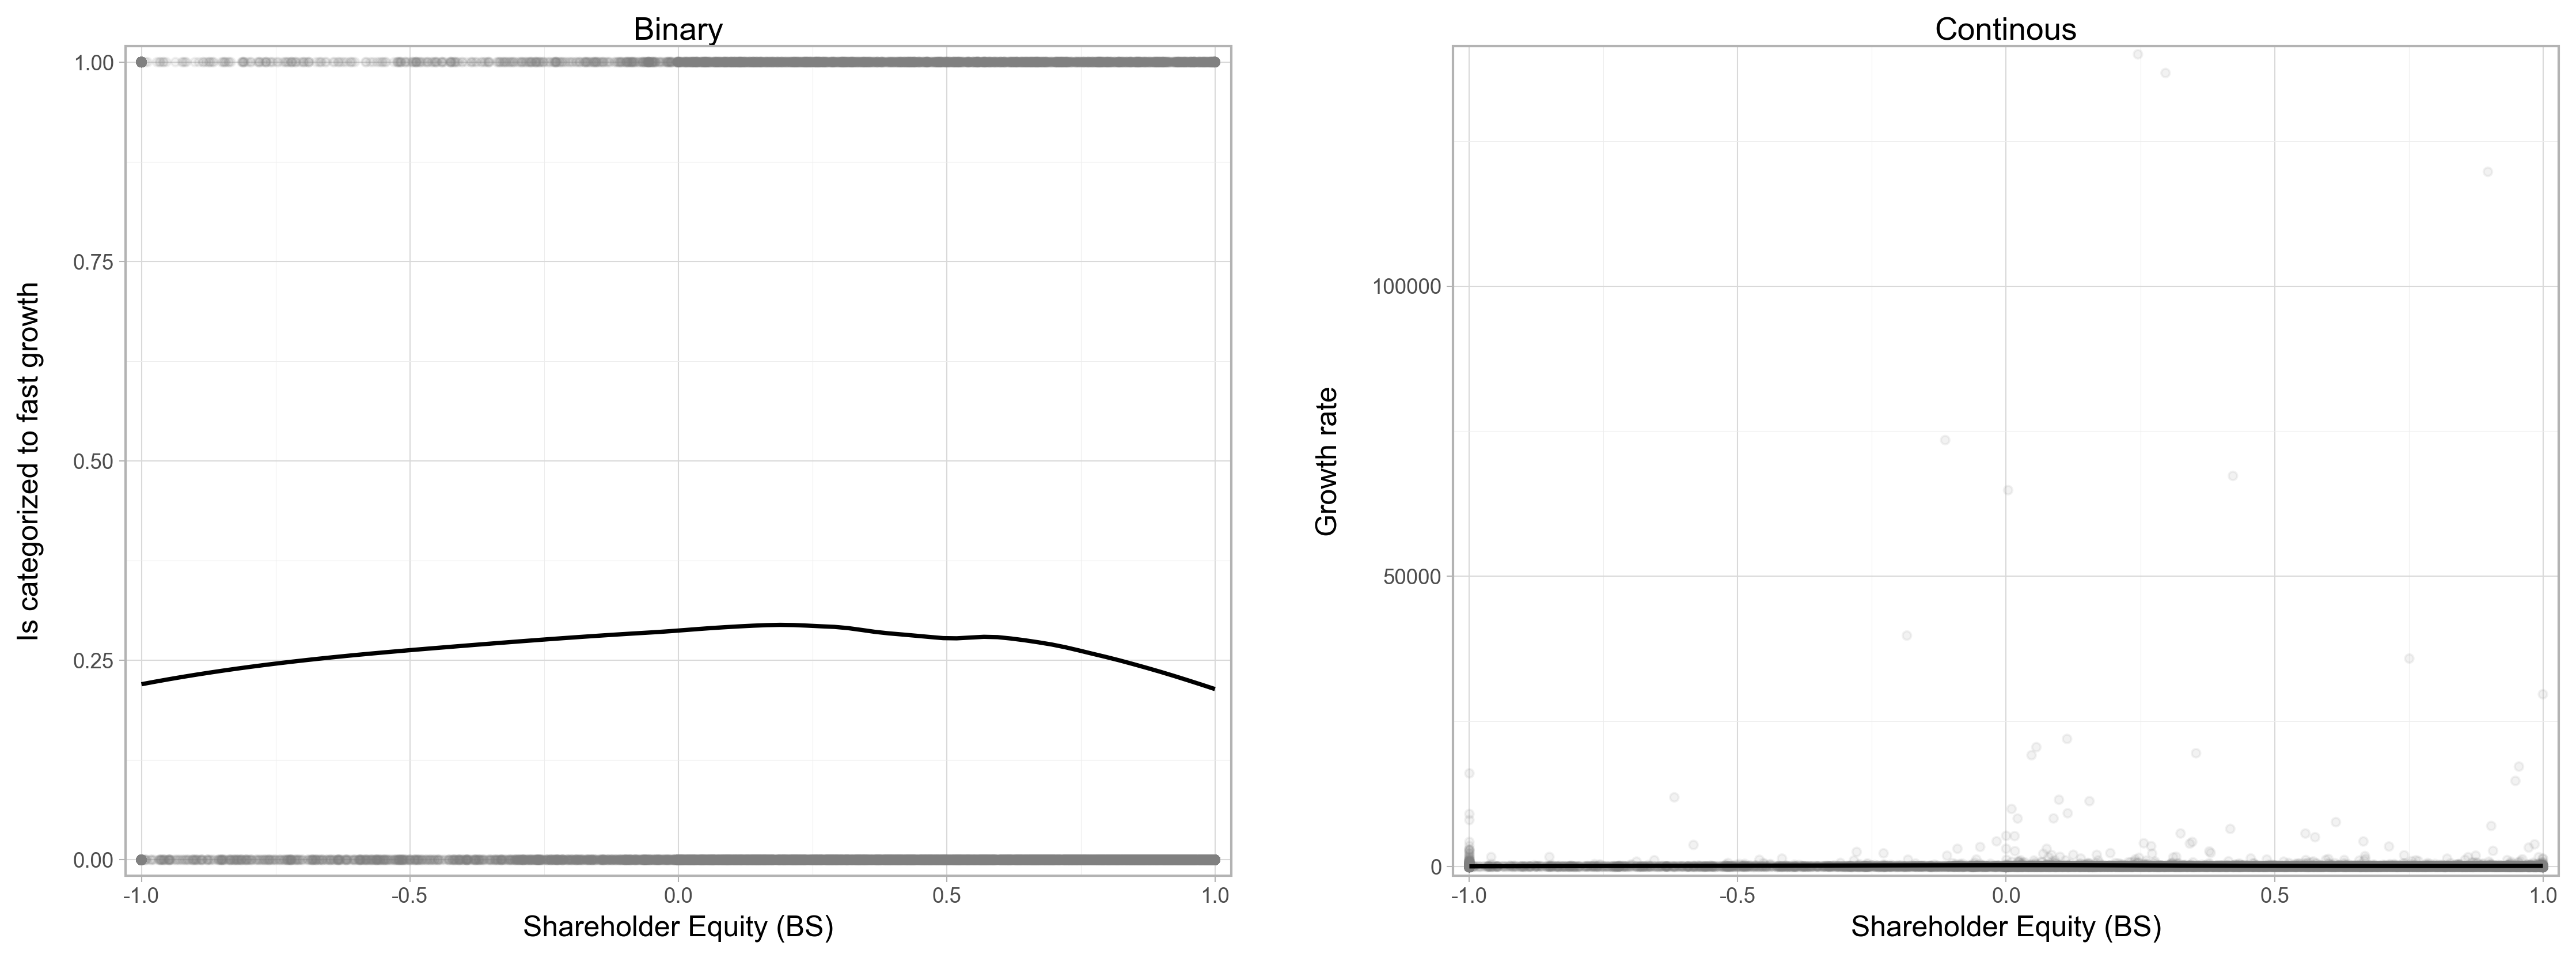

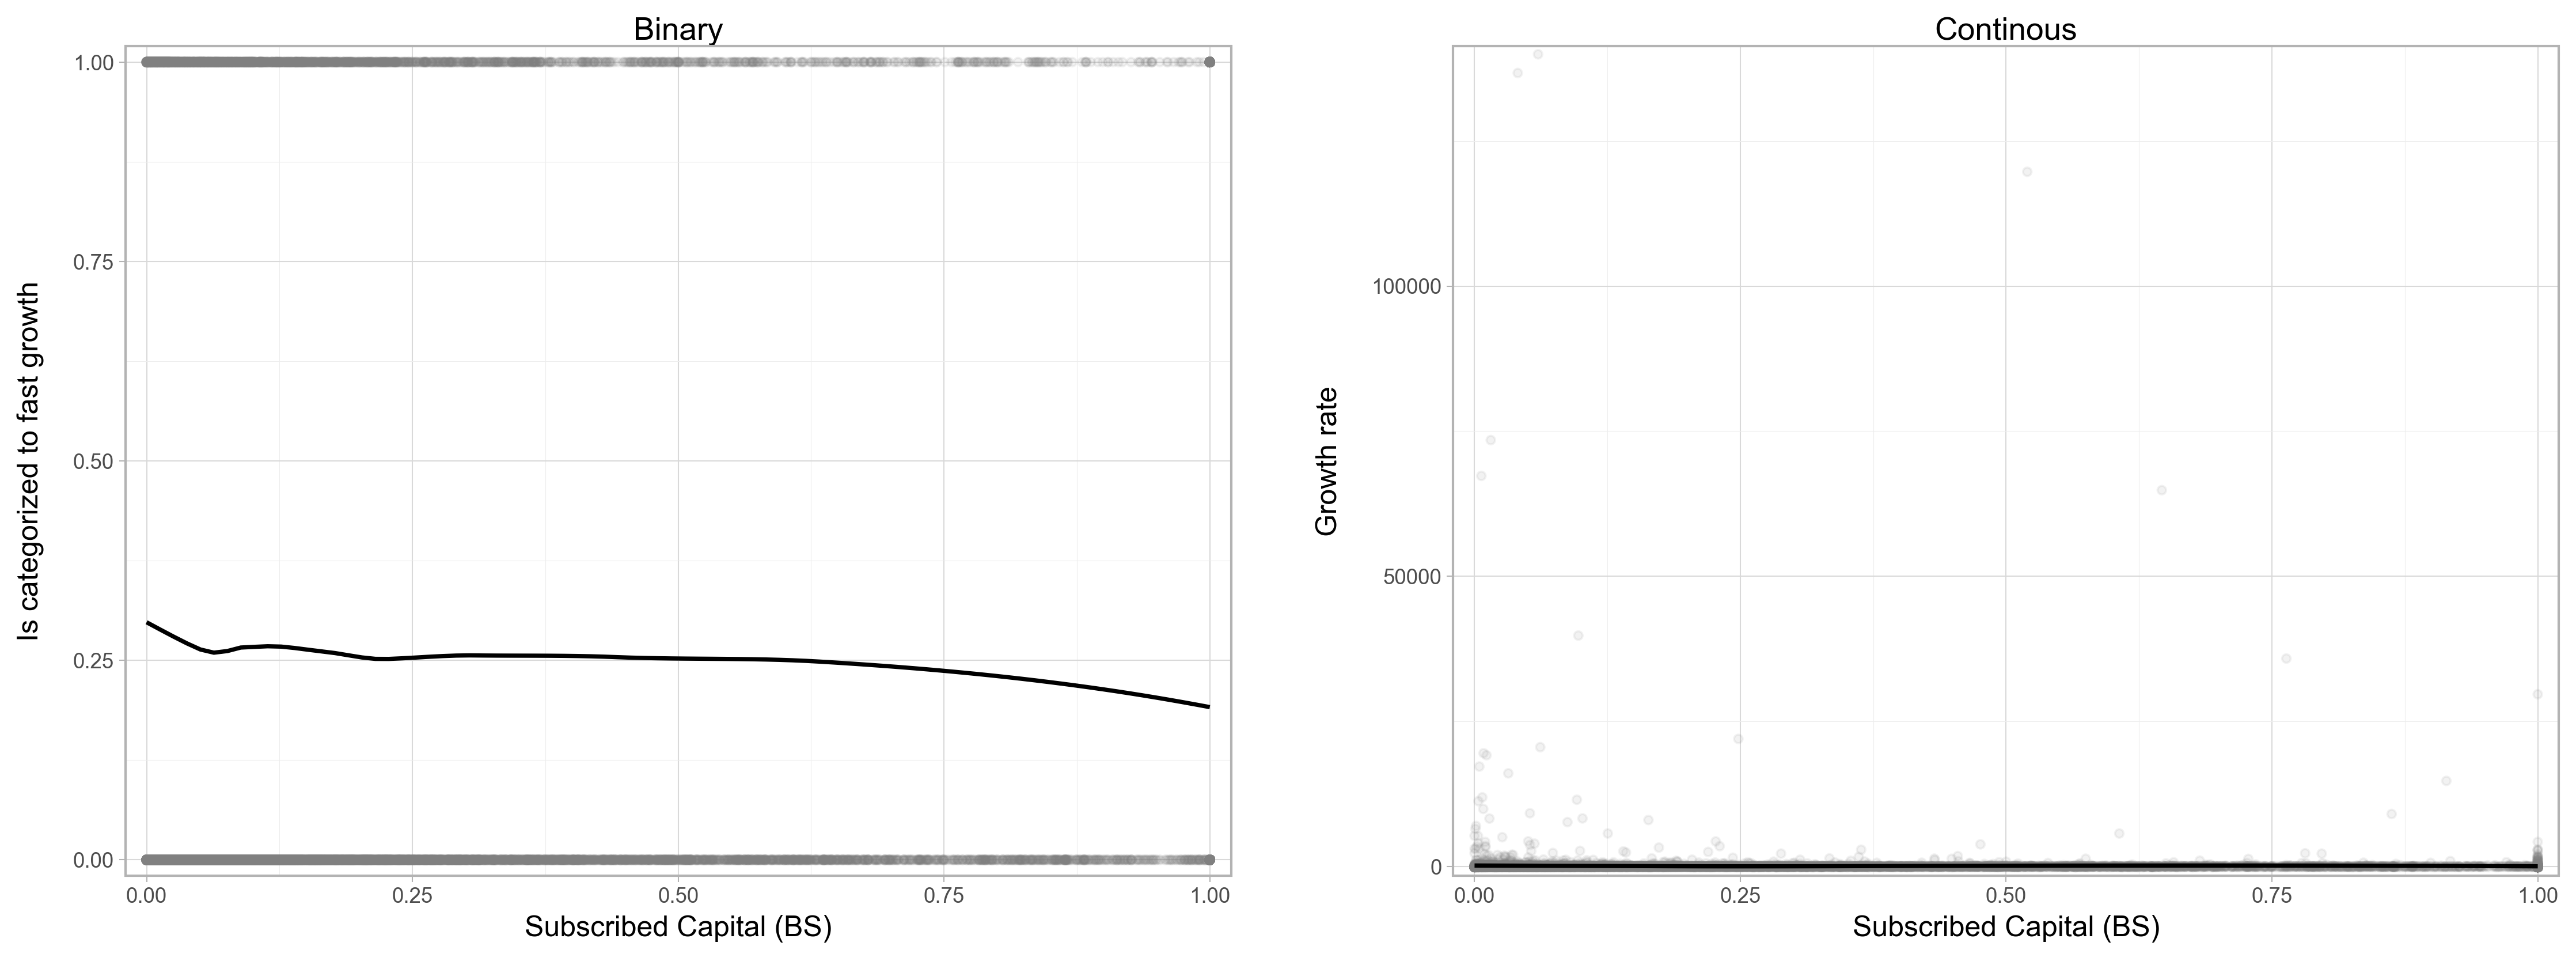

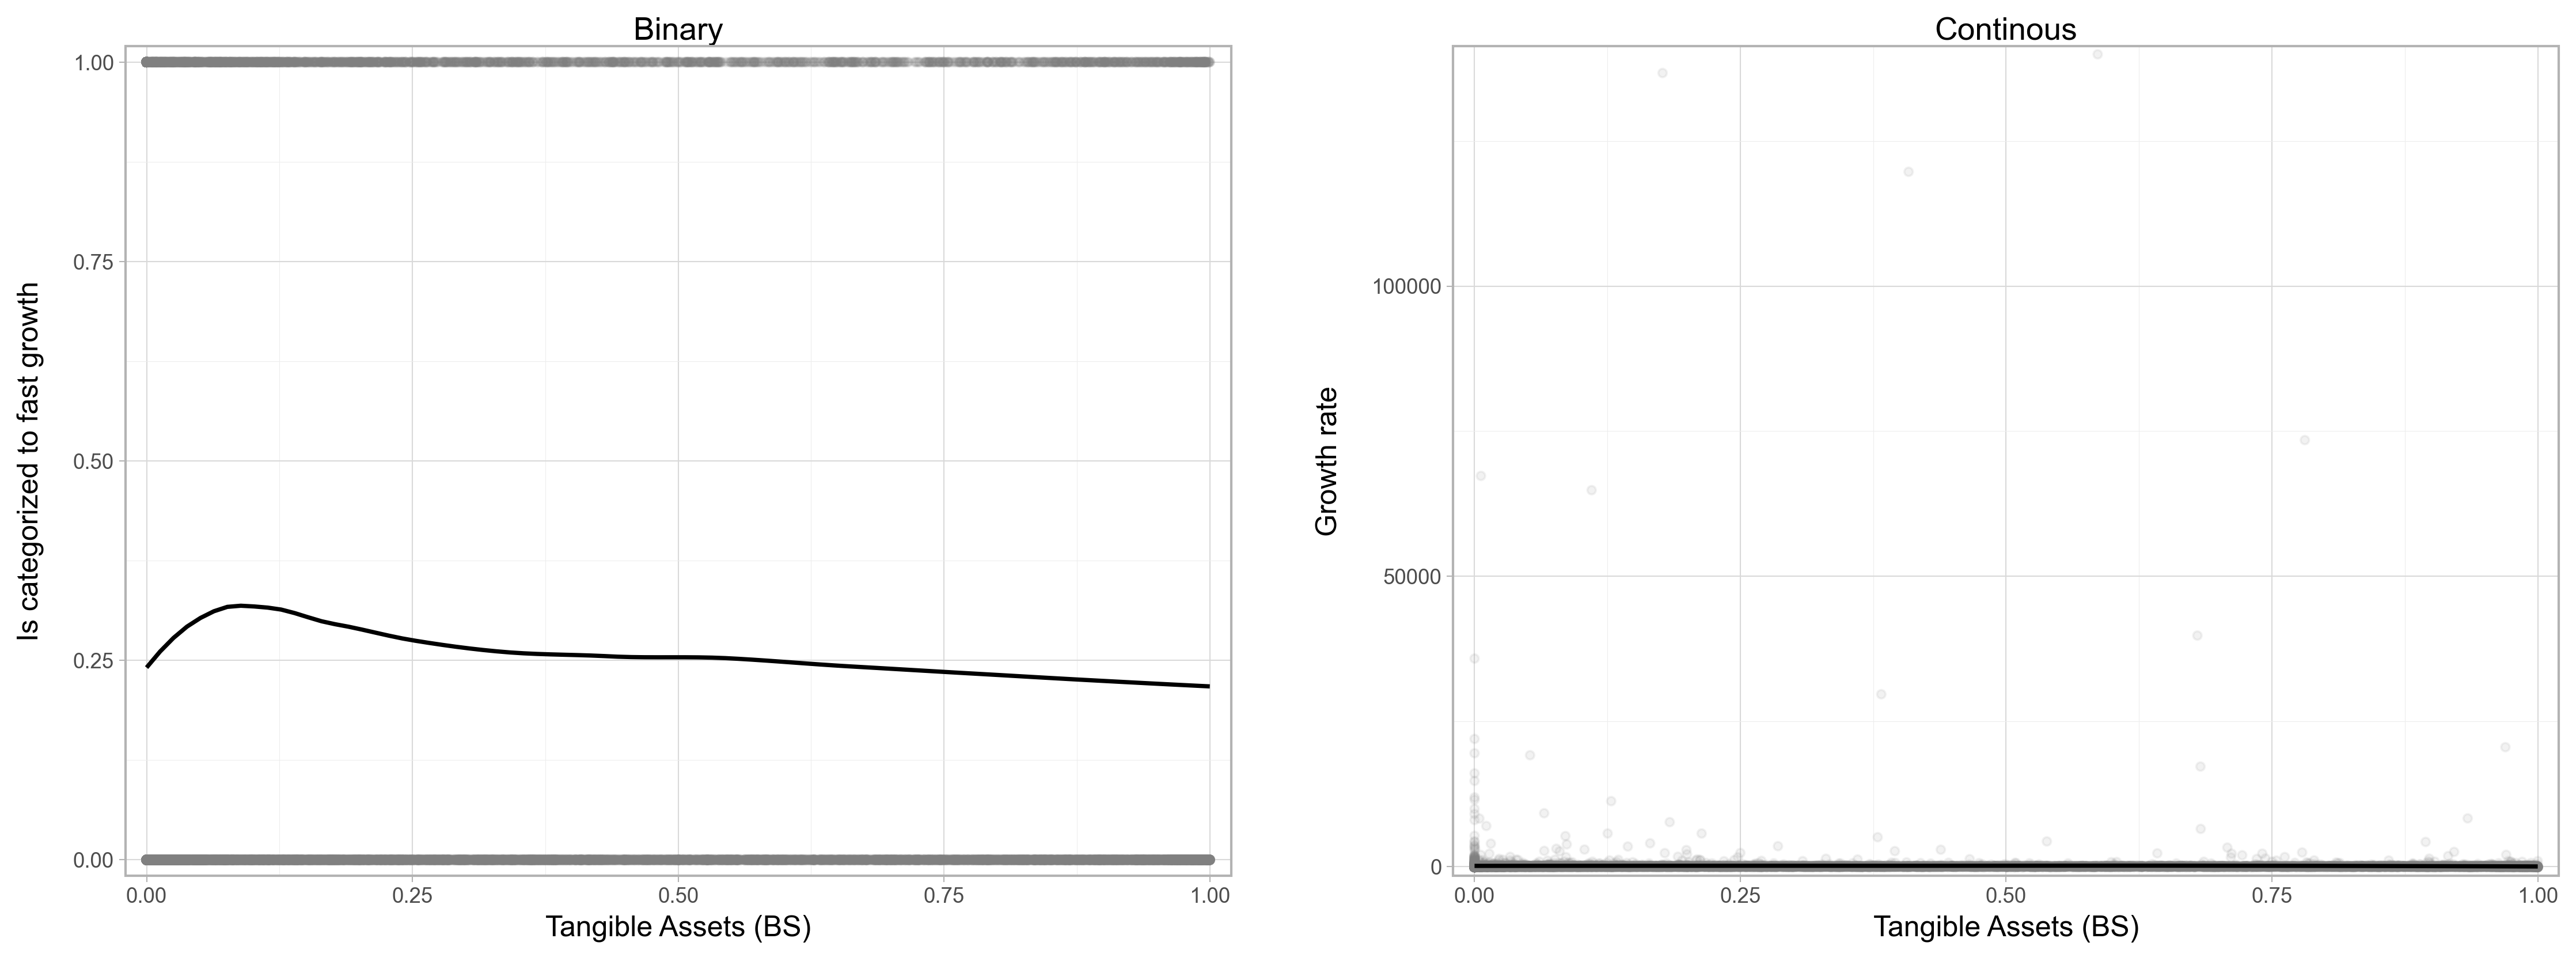

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [160]:
def plot_lowess(df, x, y, xtitle=None, ytitle=None, title=None, span=0.75):
    """
    Creates a scatter plot with a locally weighted regression (LOWESS) smoothed curve using the `plotnine` library.
    The plot shows the relationship between two variables with a smooth trend line.

    Parameters:
    -----------
    df : pandas.cleanFrame
        The input cleanFrame containing the clean to be plotted.
    x : str
        The name of the column in the cleanFrame to use for the x-axis.
    y : str
        The name of the column in the cleanFrame to use for the y-axis.
    xtitle : str, optional
        The label for the x-axis. If None, the column name `x` will be used. Default is None.
    ytitle : str, optional
        The label for the y-axis. If None, the column name `y` will be used. Default is None.
    title : str, optional
        The title of the plot. Default is None.
    span : float, optional
        The smoothing parameter for the LOWESS curve. Controls the amount of smoothing; 
        larger values result in smoother curves. Default is 0.75.

    Returns:
    --------
    plotnine.ggplot
        A `plotnine` ggplot object representing the scatter plot with the LOWESS smoothed curve.
    """
    try:
        p = (
            ggplot(df)
            + aes(x = x, y = y)
            + geom_point(color = 'grey', alpha = 0.1)
            + geom_smooth(method = 'loess', se = False, span = span)
            + theme_light()
            + scale_x_continuous(expand=(0.01, 0.01))
            + scale_y_continuous(expand=(0.01, 0.01))
            + labs(x = xtitle if xtitle is not None else x,
                   y = ytitle if ytitle is not None else y,
                   title = title,
                  )
        )
        return p
    except Exception as e:
        print(f"Error generating plot for {x} vs {y}: {e}")
        return None

vars_to_plot = [
    'amort', 
    'extra_exp_pl', 'extra_inc_pl', 'extra_profit_loss_pl', 
    'inc_bef_tax_pl', 'inventories_pl', 'material_exp_pl', 'profit_loss_year_pl', 'personnel_exp_pl', 'intang_assets_bs', 
    'curr_liab_bs', 'fixed_assets_bs', 'liq_assets_bs', 'curr_assets_bs', 'share_eq_bs', 'subscribed_cap_bs', 'tang_assets_bs'
]

labels = [
    'Amortization', 'Extra Expenditures (PL)', 'Extra Income (PL)', 'Extra Profit/Loss (PL)', 
    'Income Before Tax (PL)', 'Inventories (PL)', 'Material Expenditures (PL)', 'Profit/Loss Year (PL)', 'Personnel Expenditures (PL)', 
    'Intangible Assets (Balance Sheet)', 'Current Liabilities (BS)', 'Fixed Assets (BS)', 'Liquid Assets (BS)', 'Current Assets (BS)', 
    'Shareholder Equity (BS)', 'Subscribed Capital (BS)', 'Tangible Assets (BS)'
]

for i in range(len(labels)):
    pw.basefigure.clear()
    
    try:
        p1 = plot_lowess(data_train, vars_to_plot[i], 'f_growth', labels[i], 'Is categorized to fast growth', 'Binary', 0.5)
        p1 = pw.load_ggplot(p1)  # Attempt to load the plot

    except Exception as e:
        print(f"Error in plotting {labels[i]} (f_growth): {e}")
        p1 = None  # Set p1 to None if error occurs

    try:
        p2 = plot_lowess(data_train, vars_to_plot[i], 'growth', labels[i], 'Growth rate', 'Continous', 0.75)
        p2 = pw.load_ggplot(p2)  # Attempt to load the plot

    except Exception as e:
        print(f"Error in plotting {labels[i]} (growth): {e}")
        p2 = None  # Set p2 to None if error occurs
    
    # Only combine and display plots if both p1 and p2 are not None
    if p1 is not None and p2 is not None:
        combined = p1 | p2
        display(combined)
    else:
        print(f"Skipping combination of plots for {labels[i]} due to errors.")



### OLS

In [215]:
M1 = [
    "lspline(amort, [125000])",
    "inventories_pl",
    "lspline(material_exp_pl, [0.9])",
    "lspline(personnel_exp_pl, [0.08])",
    "lspline(fixed_assets_bs, [0.1])",
    "lspline(liq_assets_bs, [0.05])",
    "lspline(curr_assets_bs, [0.9])",
    "lspline(subscribed_cap_bs, [0.08])",
    "lspline(tang_assets_bs, [0.08])",
    "lspline(ceo_count, [2])",
    "female",
    "lspline(age, [7])",
    "new",
    "foreign_management",
    "ceo_age"   
]

all = [
    "amort",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "tang_assets_bs",
    "ceo_count",
    "foreign",
    "female",
    "age",
    "new",
    "foreign_management",
    "ceo_age"
    
]

In [217]:
logit_model_vars = [M1, all]

In [219]:
C_value_logit = [1e20]

In [226]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "f_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

In [236]:
 rmse_ols= pd.DataFrame(CV_RMSE_folds)
rmse_ols

,M1,M2
0,0.430872,0.439844
1,0.437856,0.439836
2,0.430803,0.440991
3,0.441606,0.429966
4,0.440403,0.436335


In [240]:
rmse_ols.M1.mean()

0.4363080795077933

In [242]:
rmse_ols.M2.mean()

0.4373944938789319

Based on RMSE the first modell is better, but only slightly, and model2 is less complicated.

## LASSO

In [251]:
logit_lasso_vars = [

    "amort",  
    "inc_bef_tax_pl",  
    "inventories_pl",  
    "material_exp_pl",  
    "profit_loss_year_pl", 
    "curr_liab_bs",  
    "fixed_assets_bs",  
    "liq_assets_bs",  
    "curr_assets_bs",  
    "share_eq_bs",  
    "subscribed_cap_bs",  
    "tang_assets_bs",  

    "ceo_count",  
    "foreign",  
    "female", 
    "age",  
    "new",  
    "foreign_management",  

    "ceo_age",  
    "ceo_young",  
    "age2",

    "curr_liab_bs * liq_assets_bs",  
    "profit_loss_year_pl * inc_bef_tax_pl" 
]

In [254]:
model_equation = "f_growth~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

In [262]:
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

In [265]:
lambdas = list(10 ** np.arange(-2, -5.01, -1 / 4))  
n_obs = normalized_logitvars.shape[0] * 4 / 5 

C_values = [1 / (l * n_obs) for l in lambdas]

In [268]:
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

In [276]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.010000,0.011278,0.438023
1,0.005623,0.020055,0.437219
2,0.003162,0.035663,0.436880
3,0.001778,0.063418,0.436777
4,0.001000,0.112775,0.436566
5,0.000562,0.200546,0.436515
6,0.000316,0.356626,0.436547
7,0.000178,0.634181,0.436580
8,0.000100,1.127752,0.436612
9,0.000056,2.005458,0.436635


In [279]:
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()
best_lambda_i

5

In [282]:
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

### Random Forrest

In [289]:
rfvars = [
    "amort",  
    "inc_bef_tax_pl",  
    "inventories_pl",  
    "material_exp_pl",  
    "profit_loss_year_pl", 
    "curr_liab_bs",  
    "fixed_assets_bs",  
    "liq_assets_bs",  
    "curr_assets_bs",  
    "share_eq_bs",  
    "subscribed_cap_bs",  
    "tang_assets_bs",  
    "ceo_count",  
    "foreign",  
    "female", 
    "age",  
    "new",
    "ceo_age",
]

In [291]:
y_train, rfvars_train = patsy.dmatrices("f_growth~" + "+".join(rfvars), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("f_growth~" + "+".join(rfvars), data_holdout)

In [312]:
mf = np.arange(1, 18, 3)
mss = np.arange(5, 100, 10)

grid = {
    "max_features": mf,
    "criterion": ["gini"],
    "min_samples_split": mss,
} 

In [314]:
prob_forest = RandomForestClassifier(random_state=50, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

In [316]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

In [319]:
prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,1,5,0.646718,0.433160
1,1,15,0.649728,0.432934
2,1,25,0.651944,0.432586
3,1,35,0.653400,0.432523
4,1,45,0.654374,0.432559
5,1,55,0.653519,0.432765
6,1,65,0.654230,0.432790
7,1,75,0.653508,0.432999
8,1,85,0.653810,0.433073
9,1,95,0.654119,0.433090


In [322]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_


{'criterion': 'gini', 'max_features': 4, 'min_samples_split': 95}

In [352]:
cv_auc = np.zeros([6])
for i in range(5):
    cv_auc = cv_auc + prob_forest_fit.cv_results_['split' + str(i) + '_test_roc_auc']
cv_auc = cv_auc/5
cv_auc

ValueError: operands could not be broadcast together with shapes (6,) (60,) 

In [ ]:
cv_rmse = np.zeros([6])
for i in range(5):
    cv_rmse = cv_rmse +np.sqrt(-1*(prob_forest_fit.cv_results_['split' + str(i) + '_test_neg_brier_score'])).tolist()
cv_rmse = cv_rmse/5
cv_rmse

In [ ]:
prob_forest_cv_results = pd.DataFrame({
    'max_features': prob_forest_fit.cv_results_['param_max_features'],
    'min_samples_split': prob_forest_fit.cv_results_['param_min_samples_split'],
    'cv_accuracy': cv_accuracy,
    'cv_auc': cv_auc,
    'cv_rmse': cv_rmse
})

In [ ]:
prob_forest_cv_results.style.format(
    {
        'cv_accuracy': '{:.5f}',
        'cv_auc': '{:.5f}',
        'cv_rmse': '{:.5f}'
    }
)

In [ ]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_max_features) & 
    (prob_forest_cv_results.min_samples_split == best_min_sample_split)]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

CV_RMSE['rf_p'] = prob_forest_best_results.cv_rmse.values[0]
CV_AUC['rf_p'] = prob_forest_best_results.cv_auc.values[0]

In [325]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [363]:
summary.loc["RF", "Number of Coefficients"] = "n.a."
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]
summary

NameError: name 'summary' is not defined

In [361]:
####################################################
# Import packages
####################################################
import copy
from typing import List

import numpy as np
import numpy.typing as npt
import pandas as pd
from plotnine import *

####################################################
# Define global vars
####################################################
color = ["#3a5e8cFF", "#10a53dFF", "#541352FF", "#ffcf20FF", "#2f9aa0FF"]

dark_gray = ".4"
light_gray = ".8"

da_theme = {
    "axes.edgecolor": dark_gray,
    "axes.facecolor": "white",
    "axes.linewidth": 1,
    "axes.spines.bottom": True,
    "axes.spines.left": True,
    "axes.spines.right": True,
    "axes.spines.top": True,
    "font.family": "sans-serif",
    "figure.figsize": (7, 5.5),
    "grid.color": light_gray,
    "grid.linestyle": "-",
    "text.color": "black",
    "xtick.bottom": True,
    "xtick.color": dark_gray,
    "ytick.color": dark_gray,
}


####################################################
# Define helper functions
####################################################
def seq(start: float, stop: float, by: float, round_n=3) -> list:
    """
    Custom function, used for setting the breaks of plotnine scales.

       Parameters
    ----------
    start : float
        Start of the breaks.
    stop : float
        End of the breaks.
    by : float
        Steps between breaks.
    round_n: int, default=3
        Decimals to round floats in output.
    """
    epsilon = np.finfo("float").eps

    return [
        round(x, round_n) for x in list(np.arange(start, stop + (by - epsilon), by))
    ]


def skew(l: npt.ArrayLike, round_n=3) -> float:
    return round((np.mean(l) - np.median(l)) / np.std(l), round_n)


def lspline(series: pd.Series, knots: List[float]) -> np.array:
    """Generate a linear spline design matrix for the input series based on knots.

    Parameters
    ----------
    series : pd.Series
        The input series to generate the design matrix for.
    knots : List[float]
        The list of knots to use for the linear spline.

    Returns
    -------
    np.array
        The design matrix for the linear spline."""
    vector = series.values
    columns = []

    for i, knot in enumerate(knots):
        column = np.minimum(vector, knot if i == 0 else knot - knots[i - 1])
        columns.append(column)
        vector = vector - column

    # Add the remainder as the last column
    columns.append(vector)

    # Combine columns into a design matrix
    return np.column_stack(columns)


def create_calibration_plot(
    data: pd.DataFrame,
    file_name: str,
    prob_var: str,
    actual_var: str,
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
):
    """
    Function to create calibration curve.
    Returns calibration curve on a plot.

       Parameters
    ----------
    data : pd.DataFrame
        Your dataframe, containing the actual outcome and
        the predicted probabilities of that outcome
        by a model.
    file_name : str
        Filename to save. NOTE: this is note used for now.
    prob_var : str
        Name of the variable, containin predicted
        probabilities.
    actual_var : str
        Name of the actual outcome variable.
    y_lab: str
        Label on y axis of the plot.
    n_bins : int, default=10
        The number of bins, you would like to create.
        This is because with many values for the predicted probabilities,
        we may have few observations to look at for each value.
    breaks (optional): list or None
        You can speficy the breaks of the plot.
    """

    if breaks is None:
        breaks = np.around(
            np.linspace(0, (n_bins + 1) / 10, num=n_bins + 1, endpoint=False),
            decimals=1,
        ).tolist()

    data["prob_bin"] = pd.cut(data[prob_var], breaks, right=True, include_lowest=True)

    binned_data = (
        data.groupby("prob_bin")
        .agg(
            mean_prob=(prob_var, "mean"),
            mean_actual=(actual_var, "mean"),
            n=(actual_var, "size"),
        )
        .reset_index()
    )

    return (
        ggplot(binned_data, aes("mean_prob", "mean_actual"))
        + geom_line(color=color[0], size=1, show_legend=True)
        + geom_point(color=color[0], size=1, alpha=0.7, show_legend=False, na_rm=True)
        + geom_segment(
            x=min(breaks),
            xend=max(breaks),
            y=min(breaks),
            yend=max(breaks),
            color=color[1],
            size=0.5,
        )
        + theme_bw()
        + labs(x="Predicted event probability", y=y_lab)
        + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
        + expand_limits(x=0.01, y=0.01)
        + scale_y_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
        + scale_x_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
    )


def poly(x: npt.ArrayLike, degree=1) -> pd.DataFrame:
    """
    Fit polynomial.

    These are non orthogonal factors, but it may not matter if
    we only need this for predictions (without interpreting the
    coefficients) or visualisation.

    Parameters
    ----------
    x : npt.ArrayLike
        Data array.
    degree : int, default=1
        Degree of the polynomial.
    """
    d = {}
    for i in range(degree + 1):
        if i == 1:
            d["x"] = x
        else:
            d[f"x**{i}"] = np.power(x, i)
    return pd.DataFrame(d)


def price_diff_by_variables(
    df: pd.DataFrame, factor_var: str, dummy_var: str, factor_lab: str, dummy_lab: str
) -> ggplot:
    """
    Price difference by selected factor and dummy variables.

    This function creates a barplots looking for interactions.
    Used in `ch14-airbnb-prediction.ipynb`.

        Parameters
    ----------
    df : pd.DataFrame
        Your dataframe.
    factor_var : str
        Your factor variable (like room_type).
    dummy_var : str
        The dummy variable you are interested in (like TV).
    factor_lab : str
        The label on the final plot for the `factor_var`.
    dummy_lab : str
        The label on the final plot for the `dummy_var`.
    """

    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), sd=("price", np.std), size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()

    return (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + scale_color_manual(name=dummy_lab, values=(color[1], color[0]))
        + scale_fill_manual(name=dummy_lab, values=(color[1], color[0]))
        + ylab("Mean Price")
        + xlab(factor_lab)
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
            legend_position="top",
            legend_box="vertical",
            legend_text=element_text(size=5),
            legend_title=element_text(size=5, face="bold"),
        )
    )


import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import rmse


def ols_crossvalidator(
    formula: str, data: pd.DataFrame, n_folds=5, average_rmse=True
) -> dict:
    """OLS cross-validator


    Estimates `formula` equation with OLS and returns values of RMSE, R`2, No. coefficients,
    BIC on `data`. Does k-fold cross-validation and either returns train and test RMSE for each
    fold, or return averarage train and test RMSEs.

    Parameters
    ----------
    formula : str
        Equation that is estimated by OLS.
    data : pd.DataFrame
        Database in a wide format.
    n_folds : int, default=5
        Number of folds. Must be at least 2.
    average_rmse : bool, default=True
        Whether to return the average train and test RMSE of the k-fold CV, or return
        train and test RMSE-s for each fold.

    """

    # Get dependent variable

    y = formula.split("~")[0].strip()

    # Get statistics on the whole work data

    model = smf.ols(formula, data=data).fit()

    rsquared = model.rsquared
    # n_coefficients = model.params.shape[0]
    n_coefficients = (
        model.df_model + 1
    )  # This might differ from model.params.shape[0], because of collinear predictors
    bic = model.bic
    rmse_alldata = rmse(model.predict(), data[y])

    # Calculating test and train RMSE-s for each fold

    k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

    rmse_train = []
    rmse_test = []

    for train_index, test_index in k.split(data):

        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]

        model = smf.ols(formula, data=data_train).fit()

        rmse_train.append(rmse(data_train[y], model.predict(data_train)))
        rmse_test.append(rmse(data_test[y], model.predict(data_test)))

    if average_rmse:
        rmse_train = np.mean(rmse_train)
        rmse_test = np.mean(rmse_test)

    return {
        "RMSE": rmse_alldata,
        "R-squared": rsquared,
        "BIC": bic,
        "Coefficients": n_coefficients,
        "Training RMSE": rmse_train,
        "Test RMSE": rmse_test,
    }


import statsmodels


def point_predict_with_conf_int(
    regression: statsmodels.regression.linear_model.RegressionResultsWrapper,
    new_datapoint: pd.DataFrame,
    interval_precision=0.95,
    round_n=2,
) -> dict:
    """
    Does point prediction and interval prediction for a new datapoint.

        Parameters
    ----------
    regression : statsmodels.regression.linear_model.RegressionResultsWrapper
        Fitted regression model.
    new_datapoint : pd.DataFrame
        Database containing a new observation.
    interval_precision : float, default=0.95
        Precision of interval prediction.
    round_n: int, default=2
        Decimals to round floats in output.
    """

    summaryframe = regression.get_prediction(new_datapoint).summary_frame(
        alpha=1 - interval_precision
    )

    point_prediction = round(summaryframe["mean"].values[0], round_n)

    conf_int = [
        round(i, round_n)
        for i in summaryframe[["obs_ci_lower", "obs_ci_upper"]].values[0]
    ]

    if round_n == 0:
        point_prediction = int(point_prediction)
        conf_int = [int(i) for i in conf_int]
    else:
        pass

    return {
        "Point prediction": point_prediction,
        f"Prediction Interval ({round(interval_precision*100)}%)": conf_int,
    }


class Error(Exception):
    """Base class for other exceptions"""

    pass


class ConfintError(Error):
    """
    Error raised when a confidence interval
    does not match with required format.
    """

    def __init__(
        self,
        message="Confidence intervals are two numbers, so len(conf_int) must be 2.",
    ):
        self.message = message
        super().__init__(self.message)


def format_confidence_interval(conf_int: List[float], round_n=2) -> str:
    """Format confidence interval.

        Parameters
    ----------
    conf_int: np.array
        Array, consisting upper and upper confidence interval values.
    round_n: int, default=2
        Decimals to round floats in output.
    """
    if len(conf_int) != 2:
        raise ConfintError
    elif round_n == 0:
        return "[" + "–".join([str(int(round(i, round_n))) for i in conf_int]) + "]"
    else:
        return "[" + "–".join([str(round(i, round_n)) for i in conf_int]) + "]"


def create_sample_frame(
    vector: np.array, sample_size: int, n_samples=10000, with_replacement=False, seed=42
) -> List[np.array]:
    """
    Function for a specified number of samples.
    Draws a specified number of observations from a vector, either with or without replacement.
    Returns the matrix of samples.

    Used in `ch05-stock-market-loss-generalize.ipynb`

       Parameters
    ----------
    vector : np.array
        Vector of observations.
    sample_size : int
        Sample size, you want to draw.
        Set it len(vector) for bootstrap sampling.
    n_samples : int, default=10000
        Number of samples.
    with_replacement : bool, default=False
        Whether to perform sampling with or without
        replacement. Set `True` for bootstrap sampling.
    seed : int,default=42
        Random seed for reproducibility.
    """

    rng = np.random.default_rng(seed)
    sample_frame = np.zeros((n_samples, sample_size))
    for i in range(n_samples):
        sample_frame[i] = rng.choice(vector, size=sample_size, replace=with_replacement)

    return sample_frame


def add_margin(ax, x=0.05, y=0.05) -> None:
    """
    This will, by default, add 5% to the x and y margins to matplotlib plots.
    You can customise this using the x and y arguments when you call it.

       Parameters
    ----------
    ax : matplotlib.axes._subplots.AxesSubplot
        Vector of observations.
    x : float,default=0.05
        Margin to add for x axis.
    y : float,default=0.05
        Margin to add for x axis.
    """

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xmargin = (xlim[1] - xlim[0]) * x
    ymargin = (ylim[1] - ylim[0]) * y

    ax.set_xlim(xlim[0] - xmargin, xlim[1] + xmargin)
    ax.set_ylim(ylim[0] - ymargin, ylim[1] + ymargin)


def pool_and_categorize_continuous_variable(
    series: pd.Series, pools: List[tuple], categories: list, closed: str = "left"
):
    """
    Categorize a continuous variable based on defined intervals (pools) and corresponding categories.

    Parameters:
    series (pd.Series): The input series with continuous values to categorize.
    pools (list of tuples): A list of tuples representing the (min, max) values for each interval.
    categories (list): A list of categories corresponding to each interval in `pools`.
    closed (str): Indicates whether the intervals are closed on the 'left', 'right', 'both', or 'neither' sides.

    Returns:
    pd.Series: A series with categorized values based on the provided intervals and categories.

    Raises:
    ValueError: If the number of pools does not match the number of categories.
    """

    # Validate inputs
    if len(pools) != len(categories):
        raise ValueError("The number of pools and categories must be the same.")

    # Create bins using IntervalIndex from pools
    bins = pd.IntervalIndex.from_tuples(pools, closed=closed)

    # Perform the cut operation and map the intervals to categories
    categories_cut = pd.cut(series, bins=bins)
    categories_map = {
        interval: category for interval, category in zip(bins, categories)
    }

    return categories_cut.map(categories_map)